In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split

In [2]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [4]:
# Import src functions
sys.path.insert(0, src_folder)
from stats_and_visualisations import *
from patient_selection import *
from utilities import *

In [5]:
### --- OPTIONS
optional_exclusions = ['first_diagnosis_only', 'exclude_newborns', 'exclude_deaths']
match_on = ['age_adm_bucket', 'gender']
show_graphs = True
test_size = 0.2

In [6]:
def select_test_groups(diagnosis,
                       optional_exclusions=False,
                       match_on=False,
                       show_graphs=False):
    '''

    Function that for a given dignosis selects the patients who were diagnosed with the
    condition along with an appropriate base group

    '''

    # Import data
    subject_adm, base_adm = get_diagnosis_groups(diagnosis, optional_exclusions=optional_exclusions)
    
    if match_on:
        base_adm = take_match_control(subject_adm, base_adm, match_on=match_on)

    # Combine into a single DF
    subject_adm['target'] = 1
    base_adm['target'] = 0
    df = subject_adm.append(base_adm).reset_index(drop=True)

    if show_graphs:
        graph_comparisons(df = df, ids = 'hadm_id', group_col = 'target', group_a = 1, group_b = 0)

    df['subject_id'] = df['subject_id'].astype(int)
    df['hadm_id'] = df['hadm_id'].astype(int)
    
    df = df[['subject_id', 'hadm_id', 'target']]

    return df

In [7]:
def take_match_control(subject_adm, base_adm, match_on):    
    
    # Subjects
    subject_segments = (subject_adm.groupby(match_on)
                                   .agg({'hadm_id':'nunique'})
                                   .rename(columns={'hadm_id':'subjects_n'})
                                   .reset_index())
    subject_segments['subjects_prop'] = subject_segments['subjects_n'] / subject_segments['subjects_n'].sum()

    # Base
    base_segments = (base_adm.groupby(match_on)
                             .agg({'hadm_id':'nunique'})
                             .rename(columns={'hadm_id':'base_n'})
                             .reset_index())
    base_segments['base_prop'] = base_segments['base_n'] / base_segments['base_n'].sum()

    proportions_compare = pd.merge(subject_segments, base_segments, how='outer',
                                   left_on=match_on, right_on=match_on)

    # Compare
    proportions_compare['ratio'] = proportions_compare['base_prop'] / proportions_compare['subjects_prop']

    # Find min ratio
    lowest = proportions_compare.loc[proportions_compare['ratio'] == proportions_compare['ratio'].min()]
    total_sample_size = math.floor(lowest['base_n'] / lowest['subjects_prop'])

    proportions_compare['new_base_grp_size'] = ((total_sample_size * proportions_compare['subjects_prop'])
                                                .apply(np.floor))

    base_adm_sampled = df_empty(columns=base_adm.columns.tolist(), dtypes=base_adm.dtypes.tolist())

    for idx,row in proportions_compare.iterrows():
        
        tmp_base = base_adm.copy()
        
        n = int(row['new_base_grp_size'])
        
        match_on_values = []
        for val in match_on:
            tmp_base = tmp_base[tmp_base[val]==row[val]]
                    
        sample_df = tmp_base.sample(n=n, random_state=8)

        base_adm_sampled = base_adm_sampled.append(sample_df)
        
        del sample_df, tmp_base

    print('--> Original base group size: ', len(base_adm))
    print('--> Sampled base group size: ', len(base_adm_sampled))
    print('--> Subject group size: ', len(subject_adm))
    
    return base_adm_sampled

In [8]:
def select_patients_and_select_chartevents(diagnosis_id, diagnosis_name,
                                           test_size,
                                           optional_exclusions=False,
                                           match_on=False,
                                           show_graphs=False):
    
    print('=============')
    print(diagnosis_name)
    print('=============')
    
    df = select_test_groups(diagnosis_id, optional_exclusions=optional_exclusions,
                            match_on=match_on, show_graphs=show_graphs)
                            
    df = add_chart_data(df)

    df = add_profile_data(df, profile_data = ['gender', 'age_adm_bucket'])
    
    if show_graphs:
        # Plot a KDE for all remaining cols
        non_chart_cols = ['subject_id', 'hadm_id', 'target', 'gender', 'age_adm_bucket']
        cols = [c for c in df.columns if c not in non_chart_cols]
        for c in cols:
            plot_KDE(df, 'target', 1, 0, c)
            
    # Create dummy variables for categorical variables
    df = pd.get_dummies(df)
    
    # Shuffle and reset index
    df = df.sample(frac=1).reset_index(drop=True)
            
    # Take test and train splits
    train, test = train_test_split(df, test_size=test_size, shuffle=True, random_state=8)
    
    print("--> Training set counts: ","\n",train.target.value_counts())
    print("--> Test set counts: ","\n",test.target.value_counts())
    
    # Export to csv
    train.to_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', '{}_train.csv'.format(diagnosis_name))))
    test.to_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', '{}_test.csv'.format(diagnosis_name))))
    
    del df, train, test

acute_respiratory_failure


/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/James/Desktop/YourMD/machine_learning/mimic/src/patient_selection.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  subject_adm.drop_duplicates(inplace=True)
/Users/James/Desktop/YourMD/machine_learning/mimic/src/patient_selection.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  base_adm.drop_duplicates(inplace=True)


--> Original base group size:  29337
--> Sampled base group size:  23820
--> Subject group size:  4596


/Users/James/Desktop/YourMD/machine_learning/mimic/src/stats_and_visualisations.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


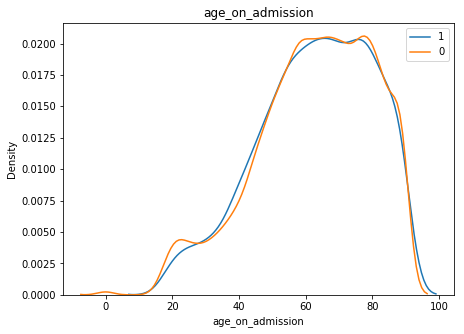

<Figure size 432x288 with 0 Axes>

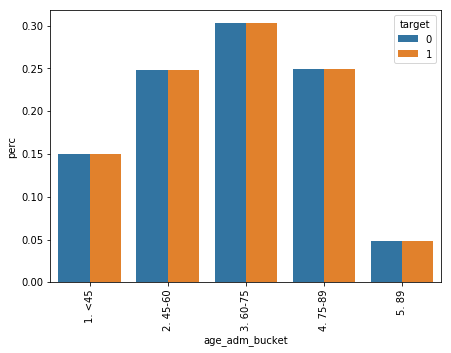

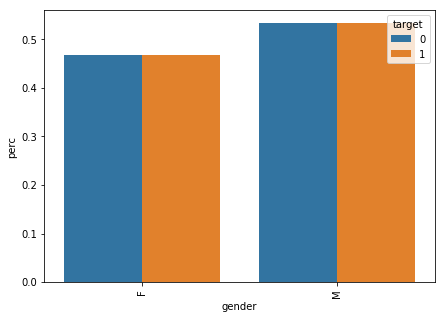

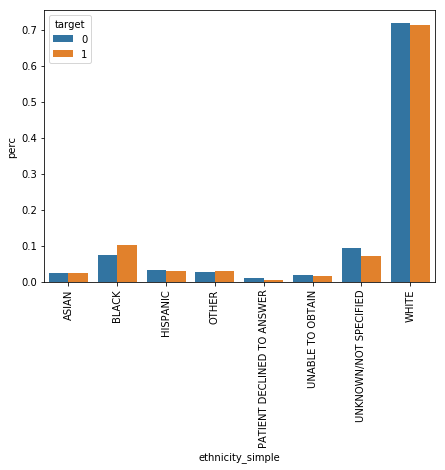

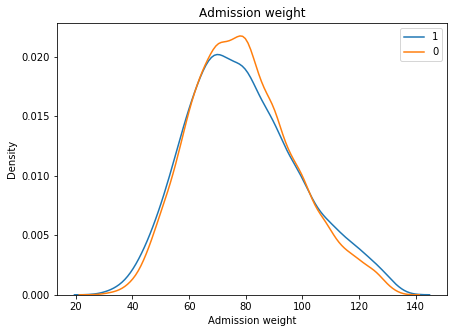

<Figure size 432x288 with 0 Axes>

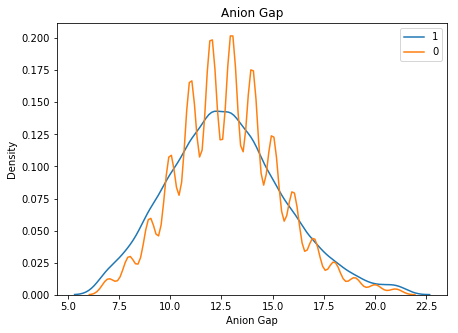

<Figure size 432x288 with 0 Axes>

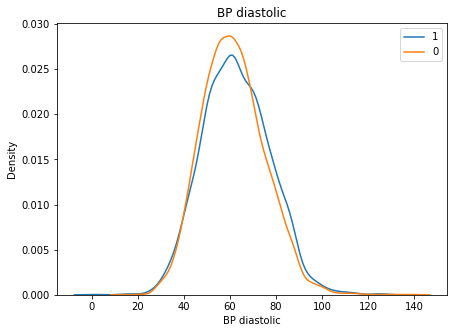

<Figure size 432x288 with 0 Axes>

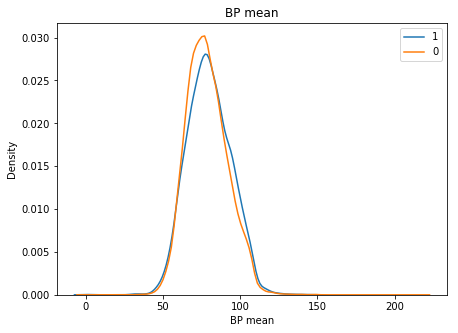

<Figure size 432x288 with 0 Axes>

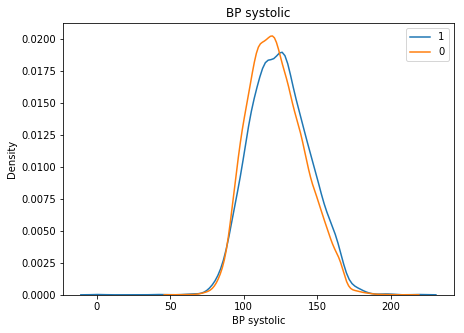

<Figure size 432x288 with 0 Axes>

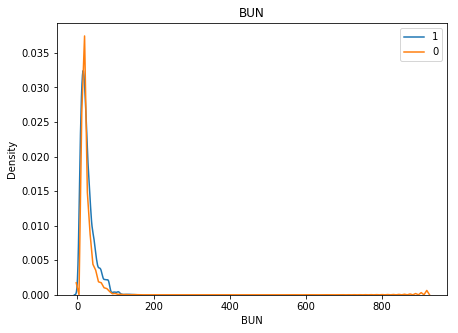

<Figure size 432x288 with 0 Axes>

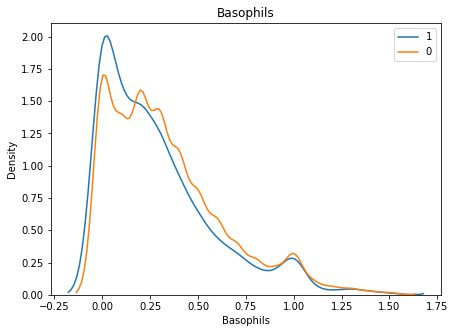

<Figure size 432x288 with 0 Axes>

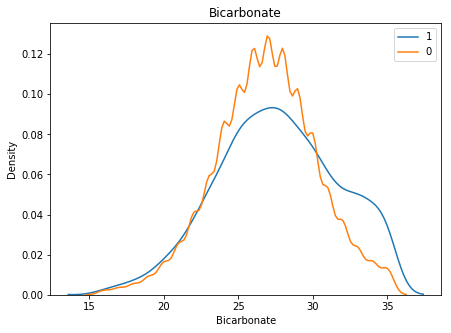

<Figure size 432x288 with 0 Axes>

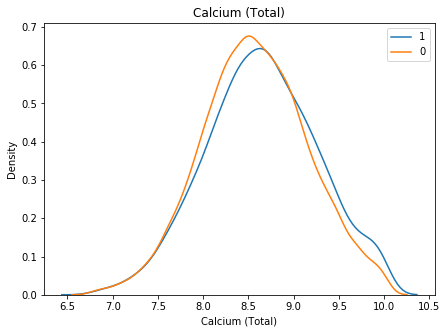

<Figure size 432x288 with 0 Axes>

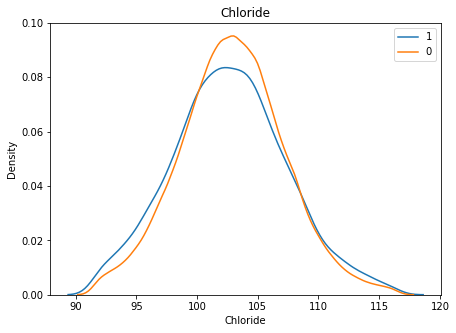

<Figure size 432x288 with 0 Axes>

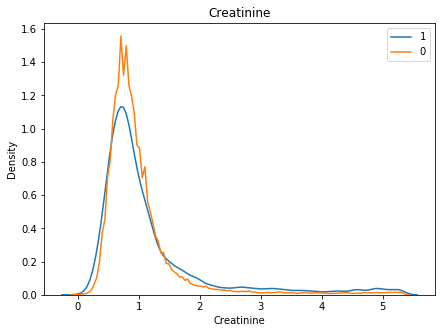

<Figure size 432x288 with 0 Axes>

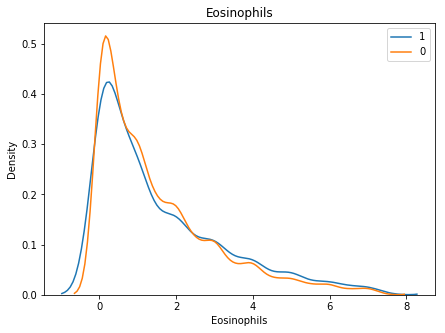

<Figure size 432x288 with 0 Axes>

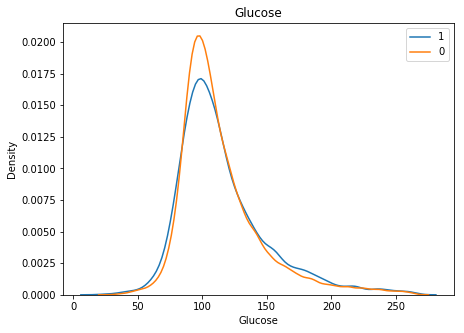

<Figure size 432x288 with 0 Axes>

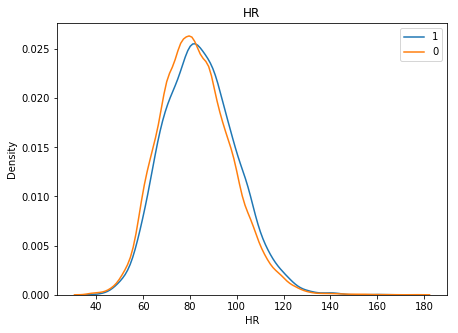

<Figure size 432x288 with 0 Axes>

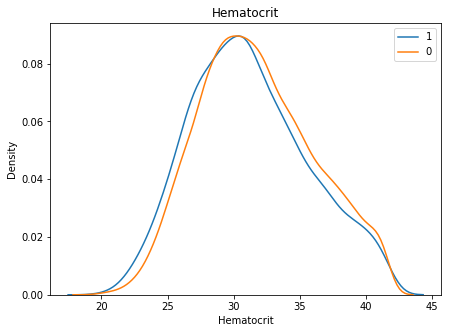

<Figure size 432x288 with 0 Axes>

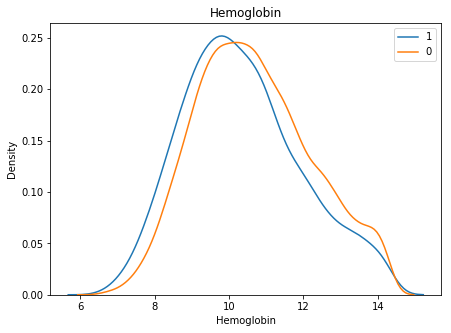

<Figure size 432x288 with 0 Axes>

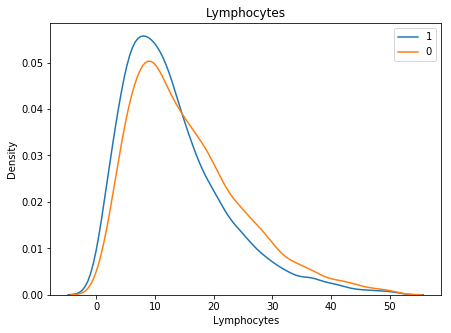

<Figure size 432x288 with 0 Axes>

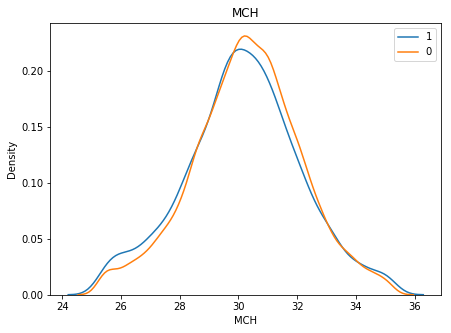

<Figure size 432x288 with 0 Axes>

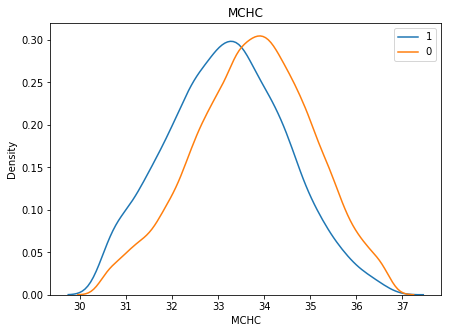

<Figure size 432x288 with 0 Axes>

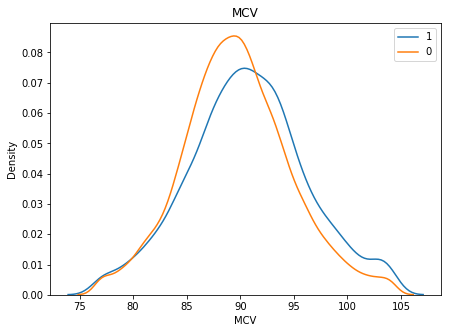

<Figure size 432x288 with 0 Axes>

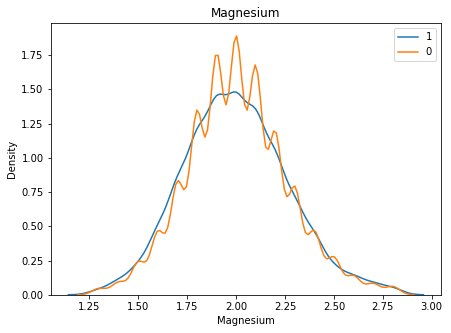

<Figure size 432x288 with 0 Axes>

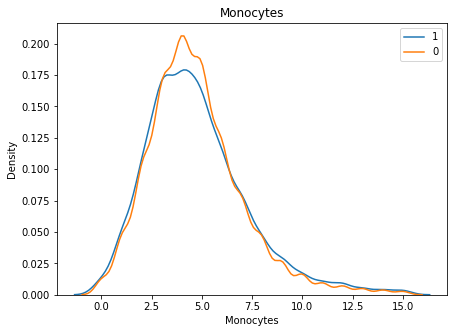

<Figure size 432x288 with 0 Axes>

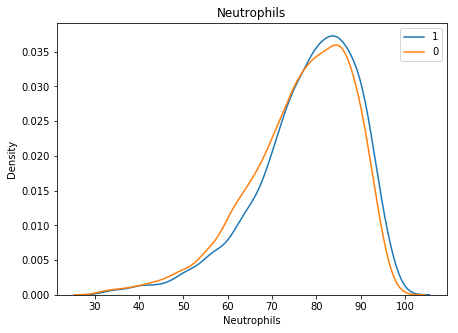

<Figure size 432x288 with 0 Axes>

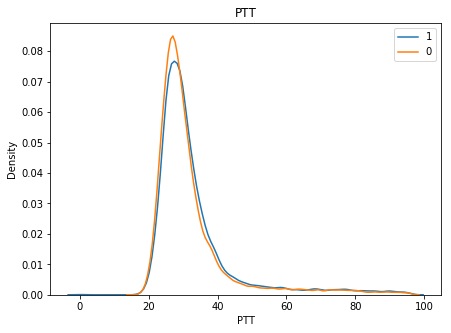

<Figure size 432x288 with 0 Axes>

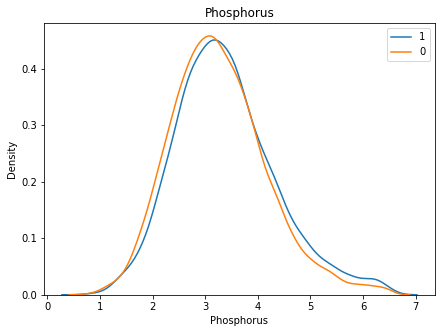

<Figure size 432x288 with 0 Axes>

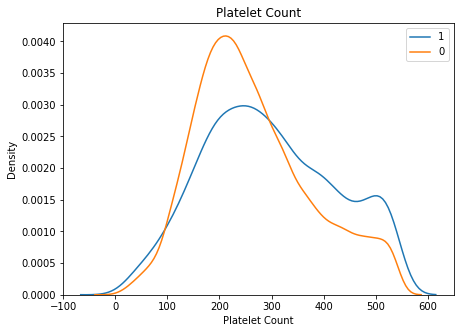

<Figure size 432x288 with 0 Axes>

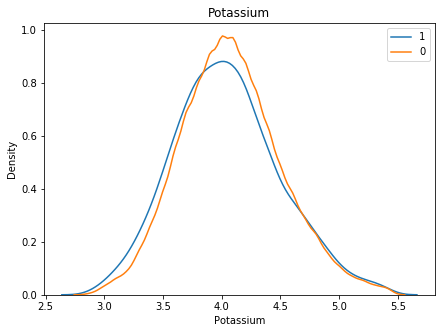

<Figure size 432x288 with 0 Axes>

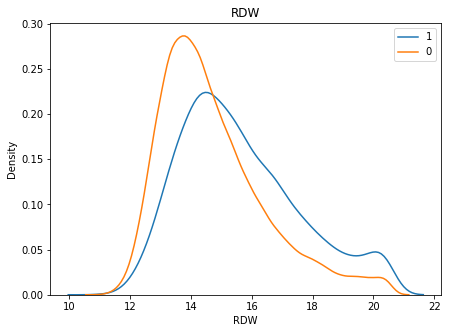

<Figure size 432x288 with 0 Axes>

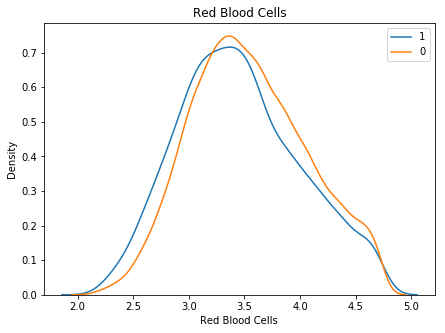

<Figure size 432x288 with 0 Axes>

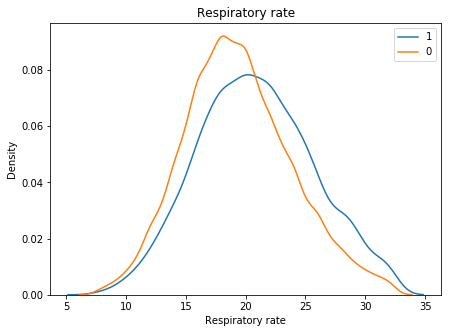

<Figure size 432x288 with 0 Axes>

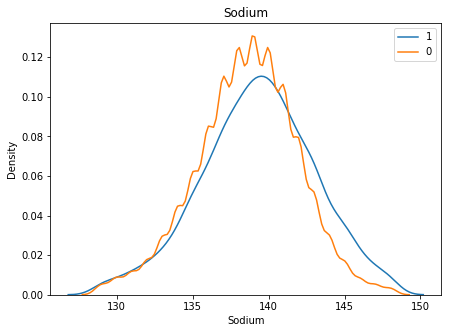

<Figure size 432x288 with 0 Axes>

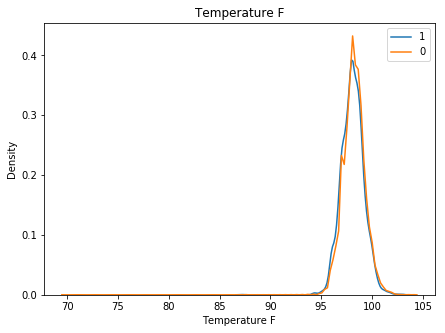

<Figure size 432x288 with 0 Axes>

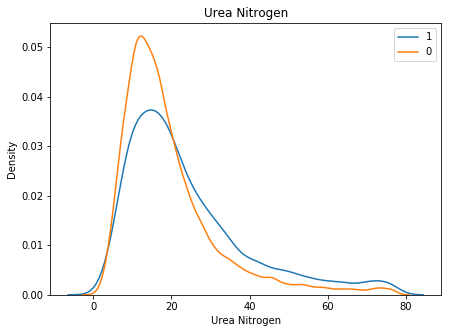

<Figure size 432x288 with 0 Axes>

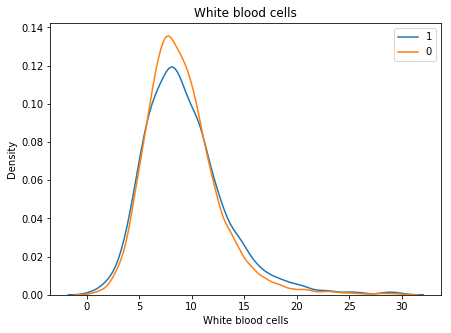

<Figure size 432x288 with 0 Axes>

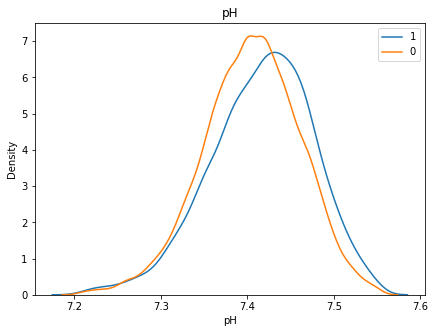

--> Training set counts:  
 0    19047
1     3685
Name: target, dtype: int64
--> Test set counts:  
 0    4773
1     911
Name: target, dtype: int64
hypertension
--> Original base group size:  18381
--> Sampled base group size:  10287
--> Subject group size:  15866


<Figure size 432x288 with 0 Axes>

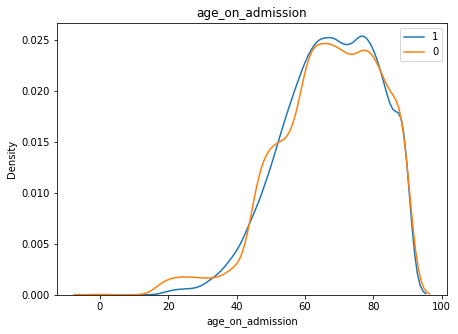

<Figure size 432x288 with 0 Axes>

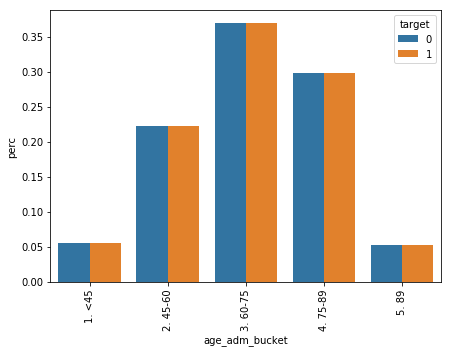

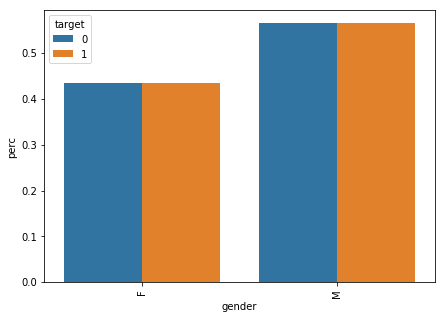

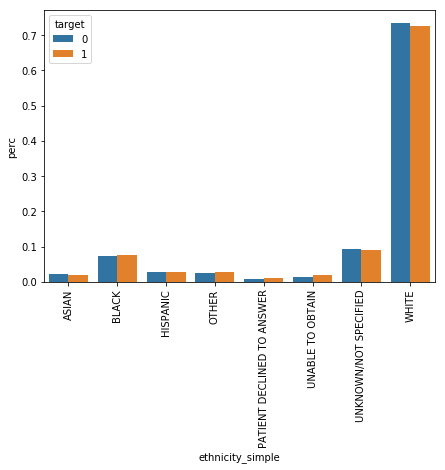

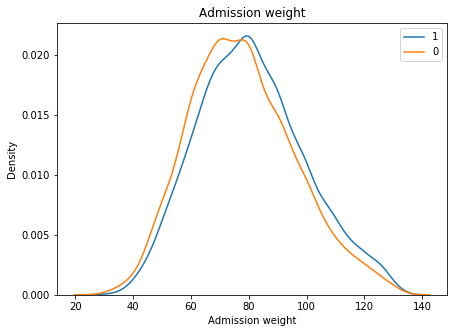

<Figure size 432x288 with 0 Axes>

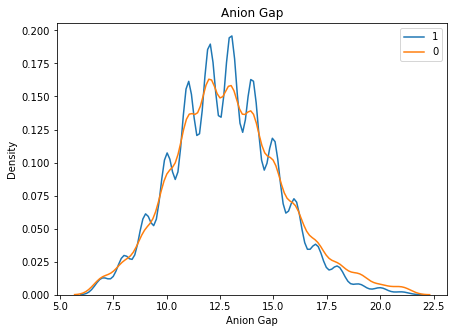

<Figure size 432x288 with 0 Axes>

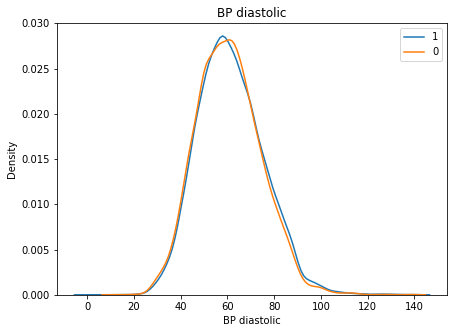

<Figure size 432x288 with 0 Axes>

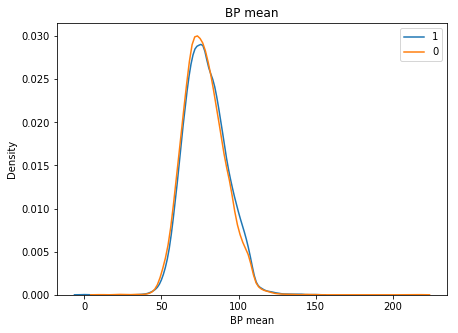

<Figure size 432x288 with 0 Axes>

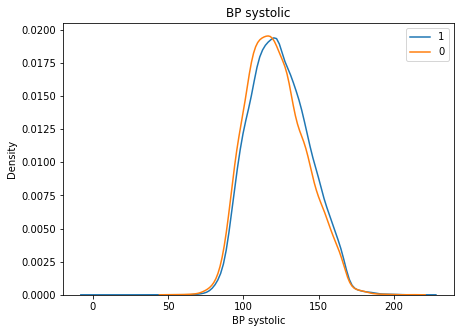

<Figure size 432x288 with 0 Axes>

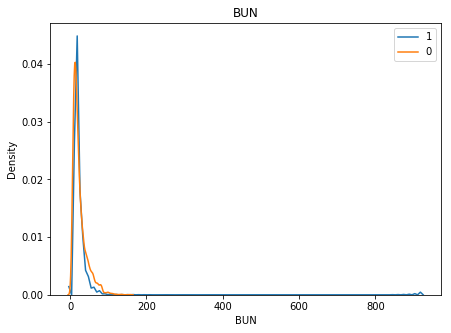

<Figure size 432x288 with 0 Axes>

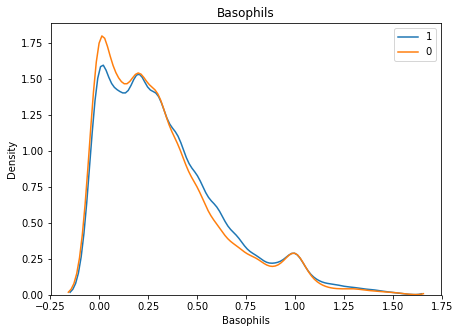

<Figure size 432x288 with 0 Axes>

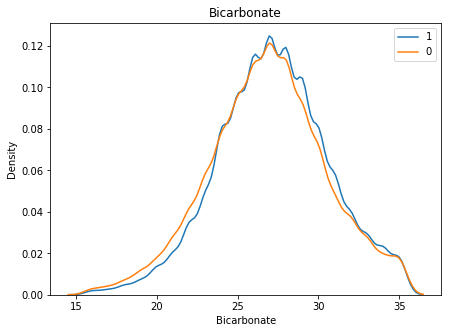

<Figure size 432x288 with 0 Axes>

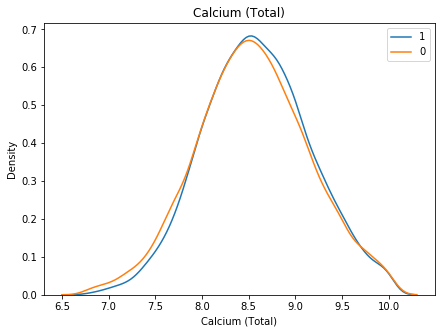

<Figure size 432x288 with 0 Axes>

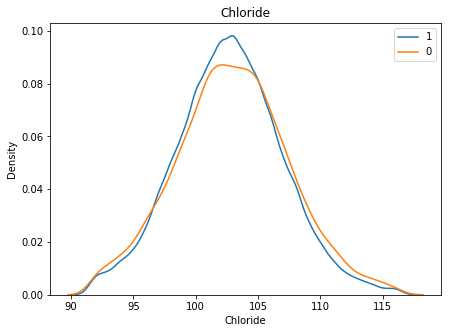

<Figure size 432x288 with 0 Axes>

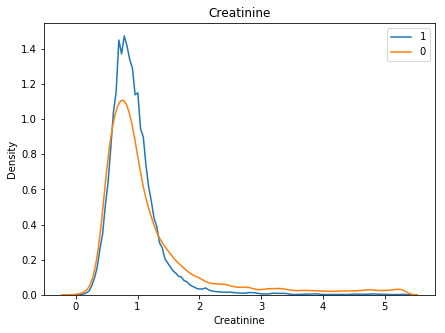

<Figure size 432x288 with 0 Axes>

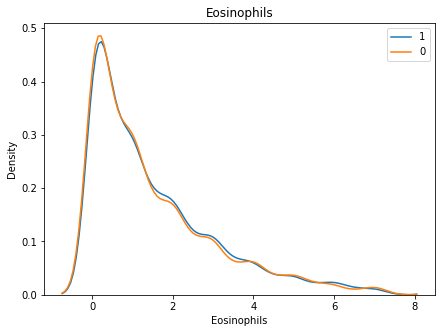

<Figure size 432x288 with 0 Axes>

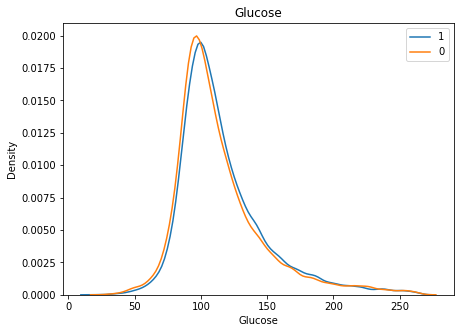

<Figure size 432x288 with 0 Axes>

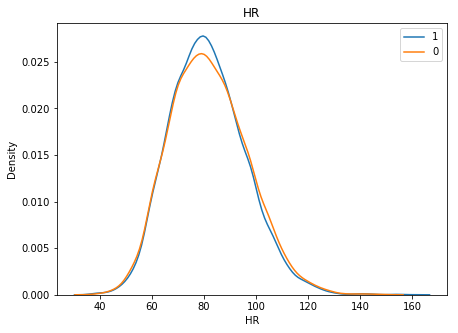

<Figure size 432x288 with 0 Axes>

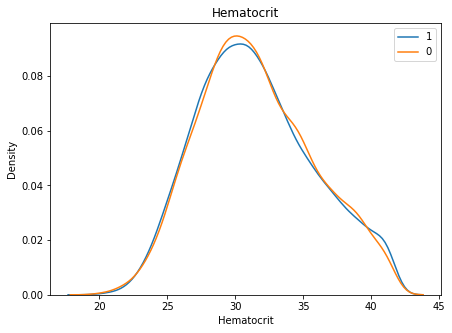

<Figure size 432x288 with 0 Axes>

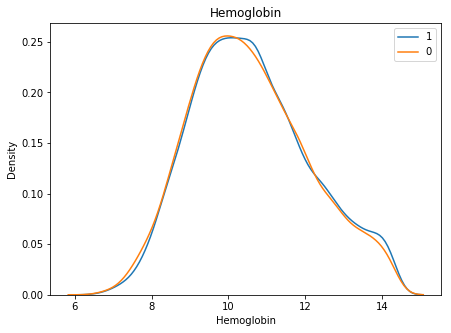

<Figure size 432x288 with 0 Axes>

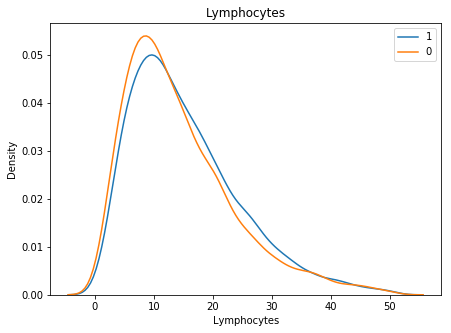

<Figure size 432x288 with 0 Axes>

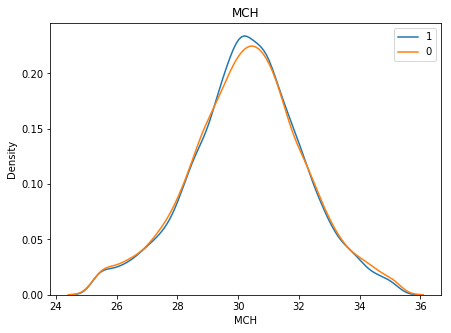

<Figure size 432x288 with 0 Axes>

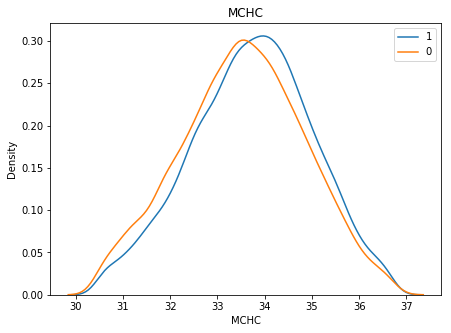

<Figure size 432x288 with 0 Axes>

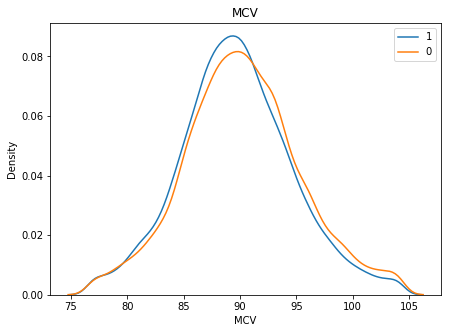

<Figure size 432x288 with 0 Axes>

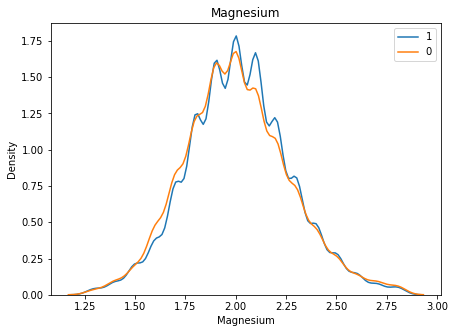

<Figure size 432x288 with 0 Axes>

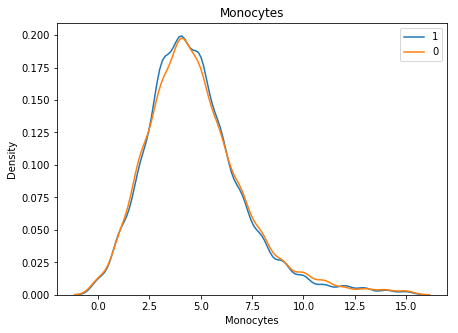

<Figure size 432x288 with 0 Axes>

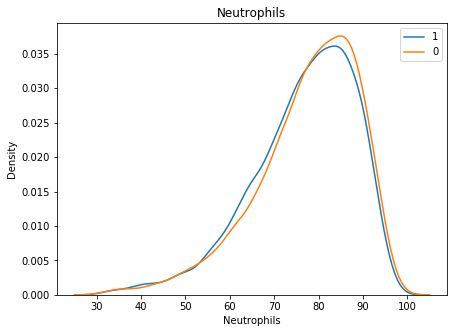

<Figure size 432x288 with 0 Axes>

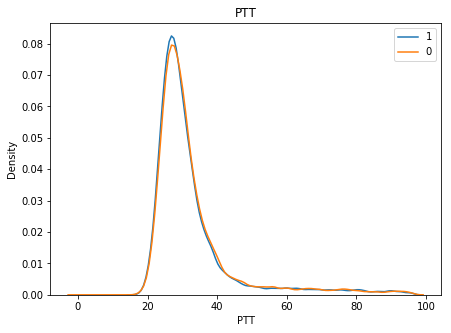

<Figure size 432x288 with 0 Axes>

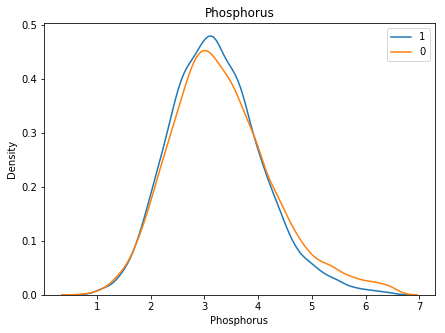

<Figure size 432x288 with 0 Axes>

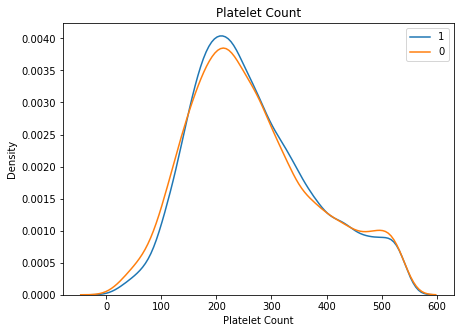

<Figure size 432x288 with 0 Axes>

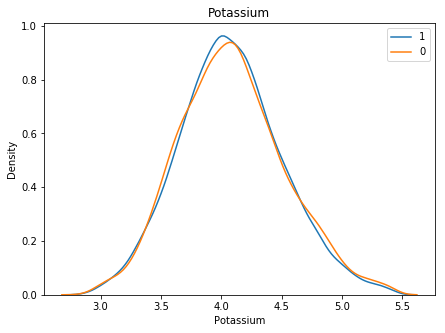

<Figure size 432x288 with 0 Axes>

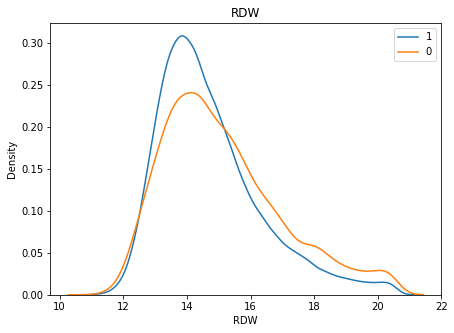

<Figure size 432x288 with 0 Axes>

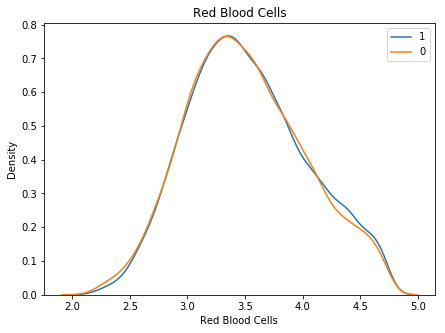

<Figure size 432x288 with 0 Axes>

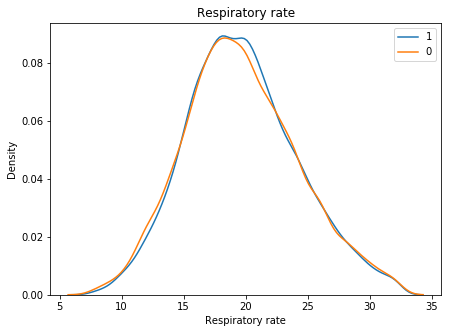

<Figure size 432x288 with 0 Axes>

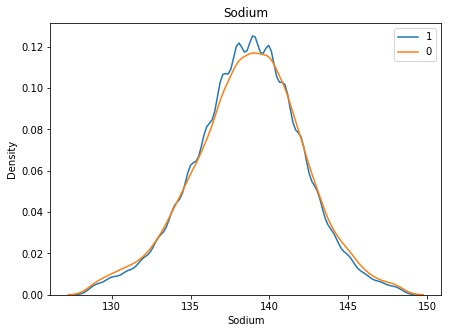

<Figure size 432x288 with 0 Axes>

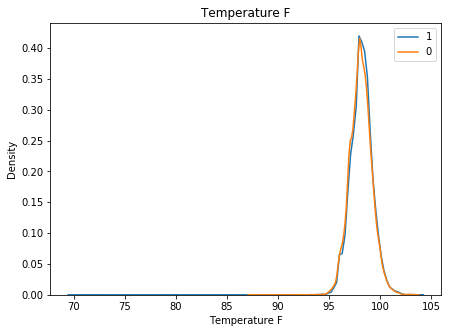

<Figure size 432x288 with 0 Axes>

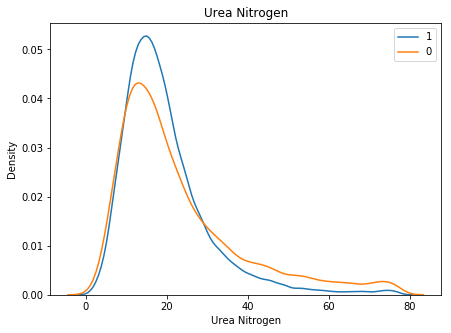

<Figure size 432x288 with 0 Axes>

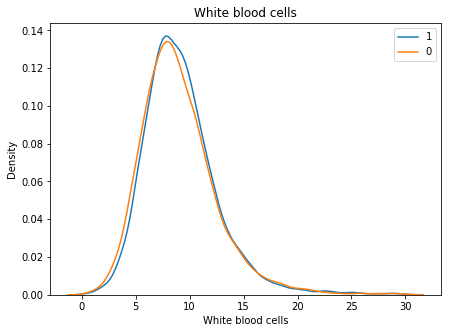

<Figure size 432x288 with 0 Axes>

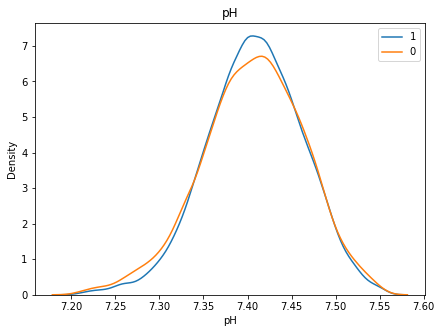

--> Training set counts:  
 1    12747
0     8175
Name: target, dtype: int64
--> Test set counts:  
 1    3119
0    2112
Name: target, dtype: int64
acute_kidney_failure
--> Original base group size:  27967
--> Sampled base group size:  9479
--> Subject group size:  6096


<Figure size 432x288 with 0 Axes>

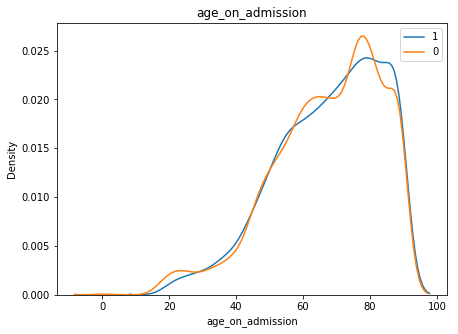

<Figure size 432x288 with 0 Axes>

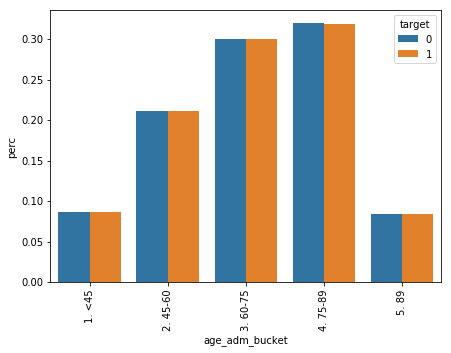

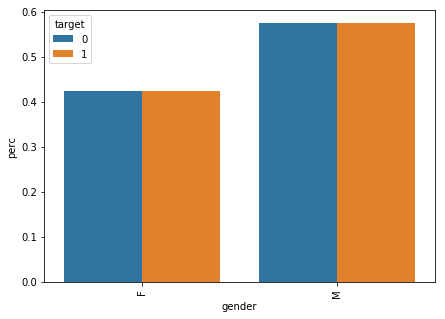

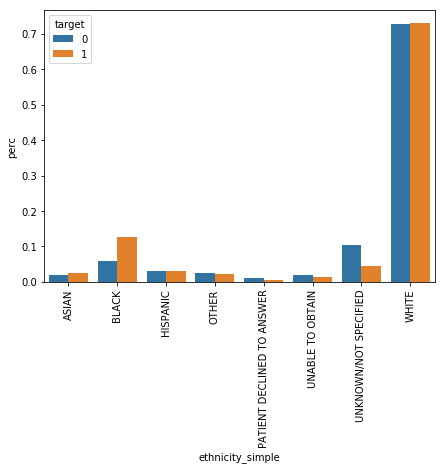

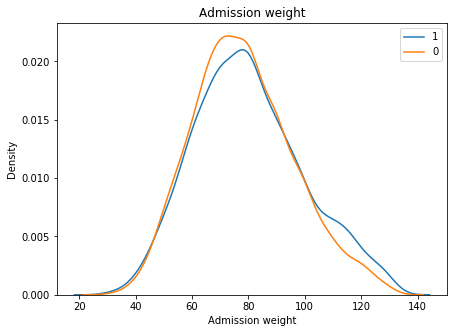

<Figure size 432x288 with 0 Axes>

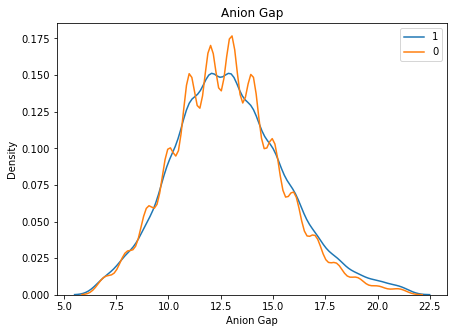

<Figure size 432x288 with 0 Axes>

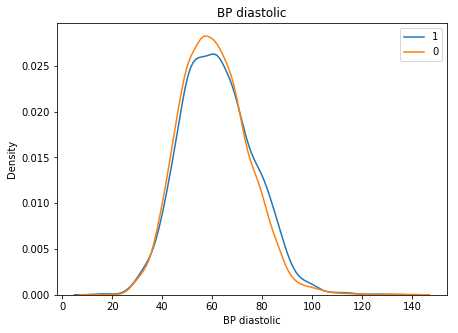

<Figure size 432x288 with 0 Axes>

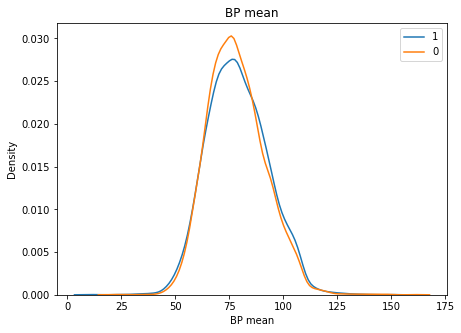

<Figure size 432x288 with 0 Axes>

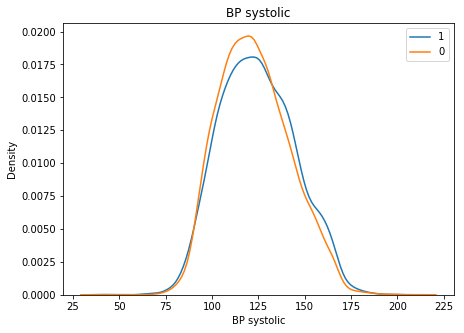

<Figure size 432x288 with 0 Axes>

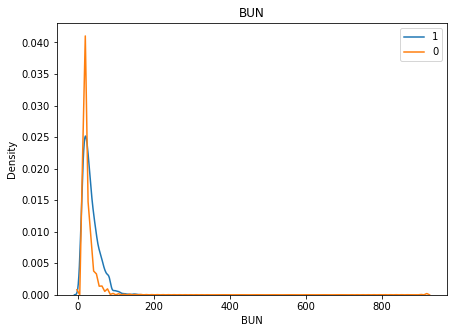

<Figure size 432x288 with 0 Axes>

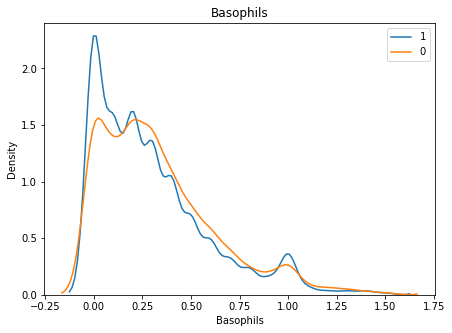

<Figure size 432x288 with 0 Axes>

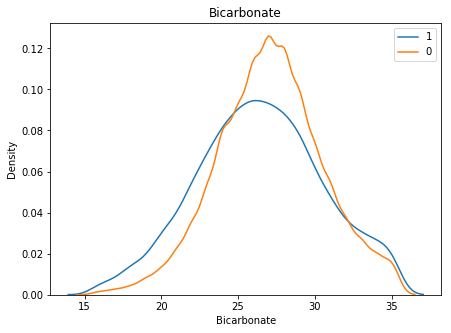

<Figure size 432x288 with 0 Axes>

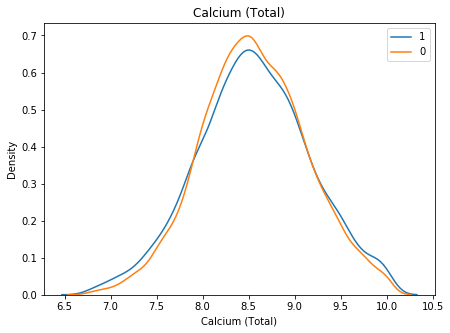

<Figure size 432x288 with 0 Axes>

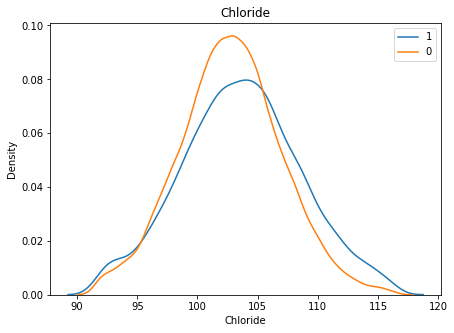

<Figure size 432x288 with 0 Axes>

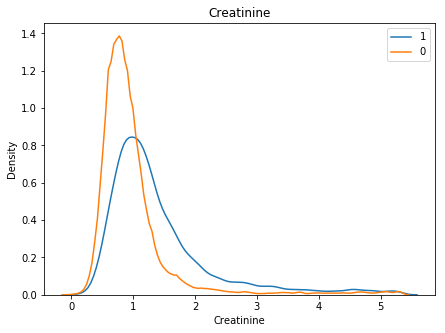

<Figure size 432x288 with 0 Axes>

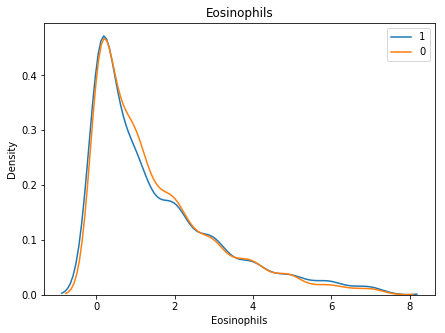

<Figure size 432x288 with 0 Axes>

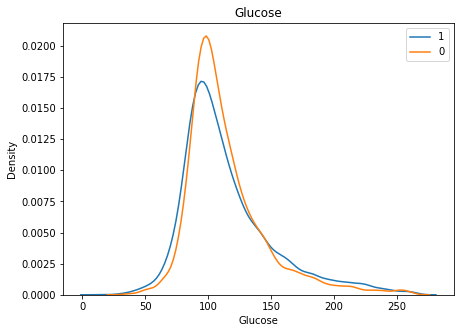

<Figure size 432x288 with 0 Axes>

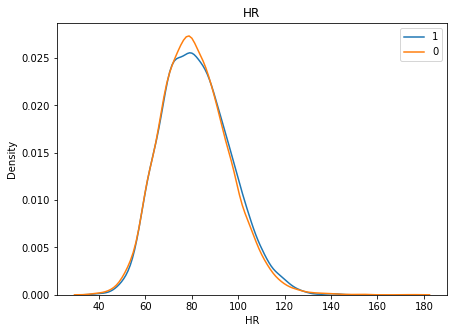

<Figure size 432x288 with 0 Axes>

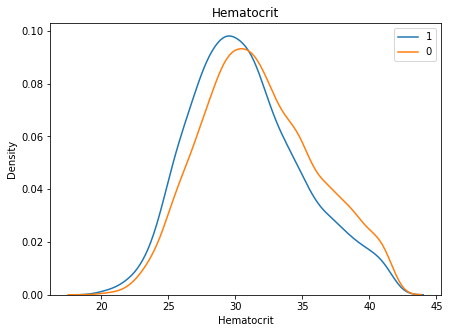

<Figure size 432x288 with 0 Axes>

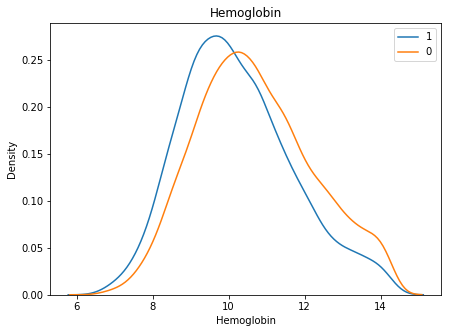

<Figure size 432x288 with 0 Axes>

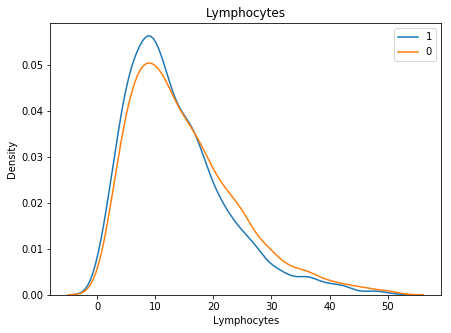

<Figure size 432x288 with 0 Axes>

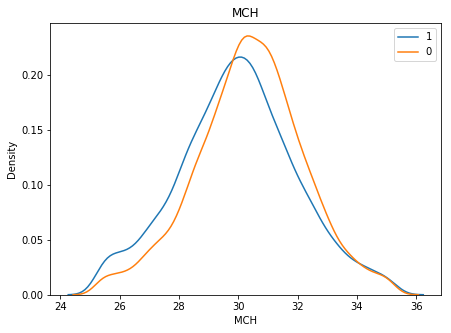

<Figure size 432x288 with 0 Axes>

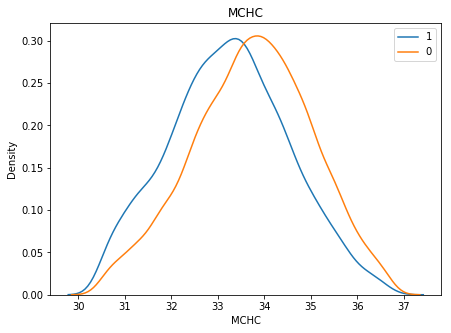

<Figure size 432x288 with 0 Axes>

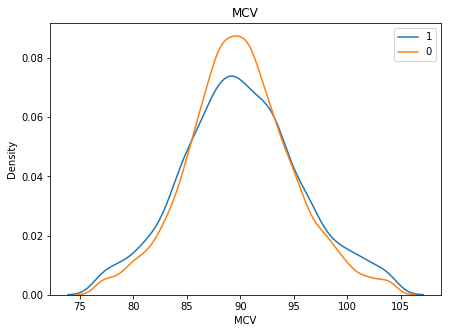

<Figure size 432x288 with 0 Axes>

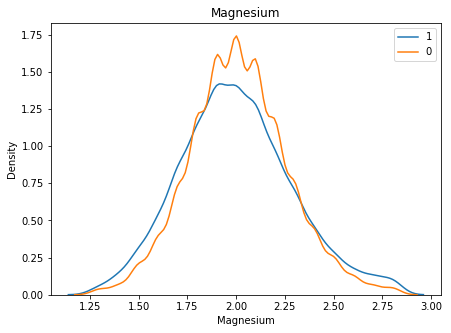

<Figure size 432x288 with 0 Axes>

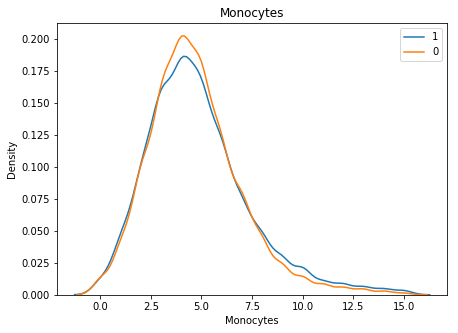

<Figure size 432x288 with 0 Axes>

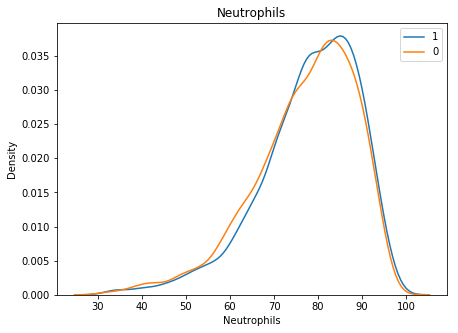

<Figure size 432x288 with 0 Axes>

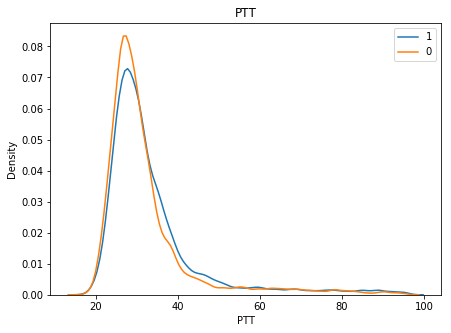

<Figure size 432x288 with 0 Axes>

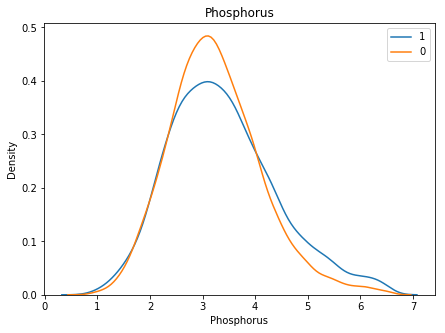

<Figure size 432x288 with 0 Axes>

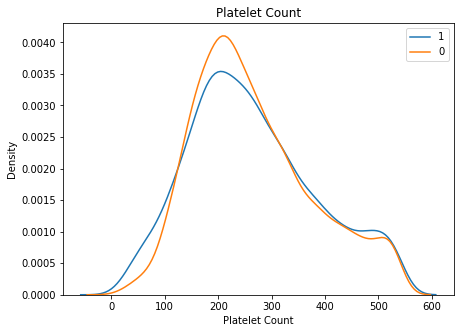

<Figure size 432x288 with 0 Axes>

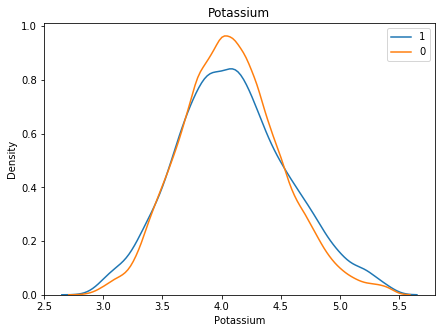

<Figure size 432x288 with 0 Axes>

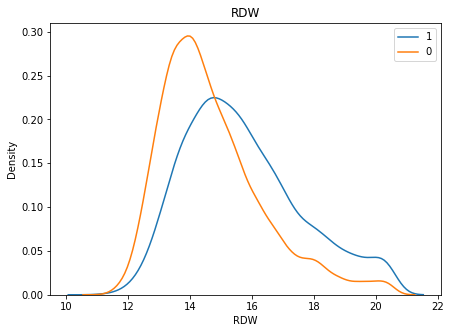

<Figure size 432x288 with 0 Axes>

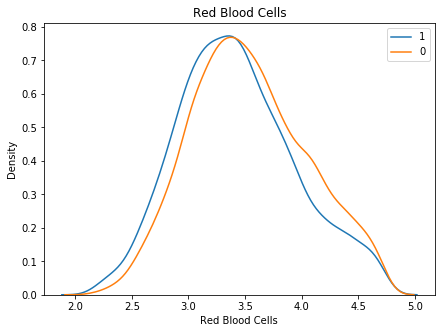

<Figure size 432x288 with 0 Axes>

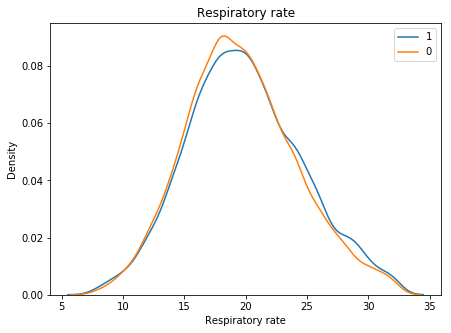

<Figure size 432x288 with 0 Axes>

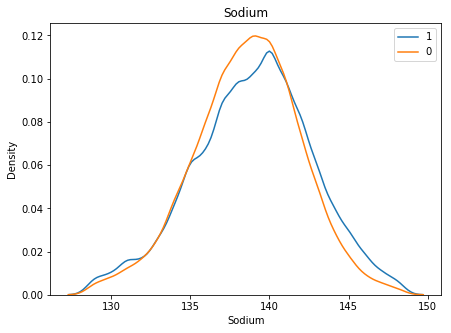

<Figure size 432x288 with 0 Axes>

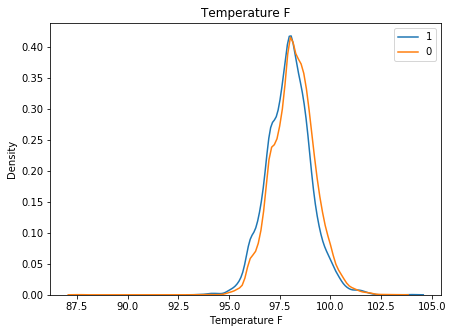

<Figure size 432x288 with 0 Axes>

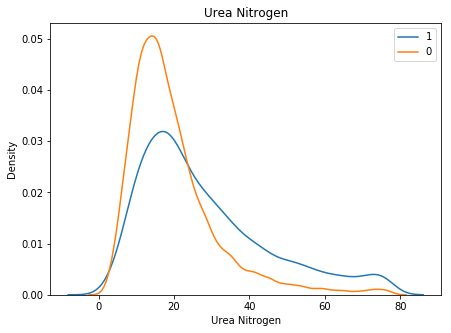

<Figure size 432x288 with 0 Axes>

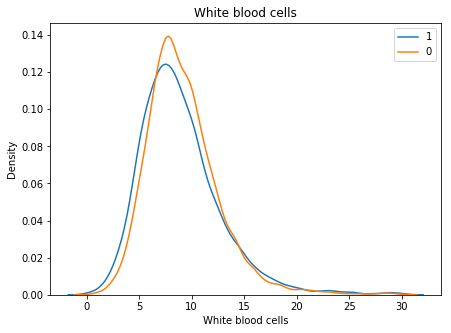

<Figure size 432x288 with 0 Axes>

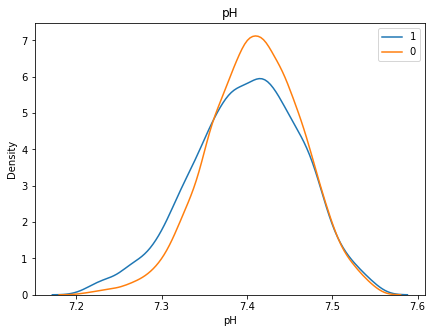

--> Training set counts:  
 0    7578
1    4882
Name: target, dtype: int64
--> Test set counts:  
 0    1901
1    1214
Name: target, dtype: int64
hyperlipidemia
--> Original base group size:  27361
--> Sampled base group size:  17635
--> Subject group size:  6916


<Figure size 432x288 with 0 Axes>

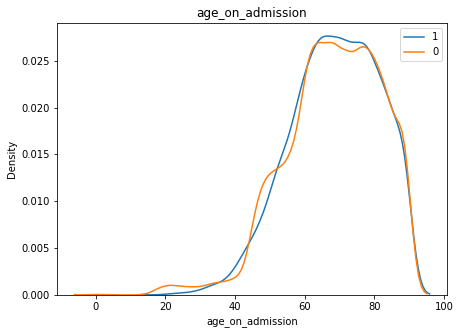

<Figure size 432x288 with 0 Axes>

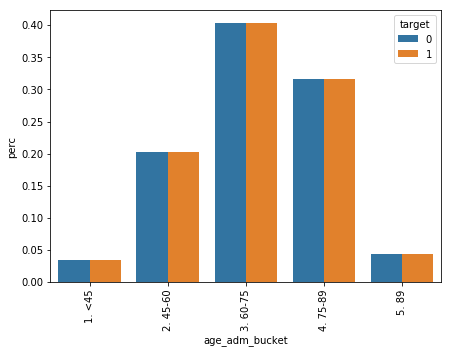

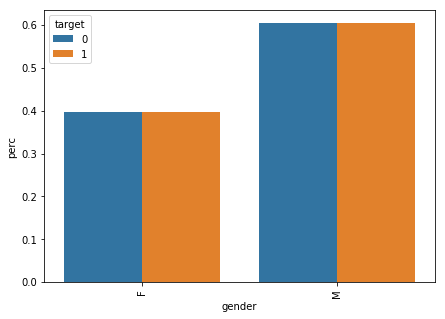

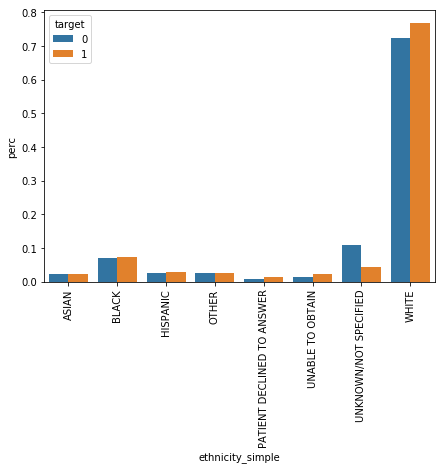

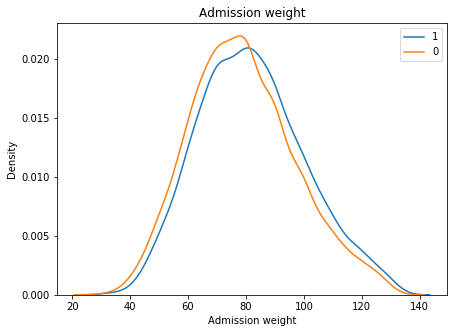

<Figure size 432x288 with 0 Axes>

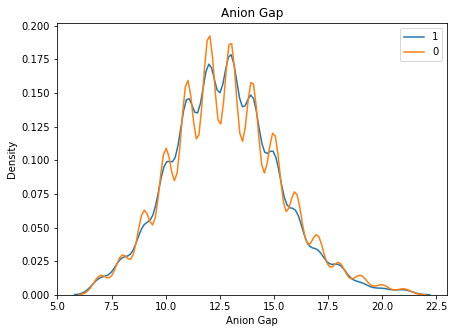

<Figure size 432x288 with 0 Axes>

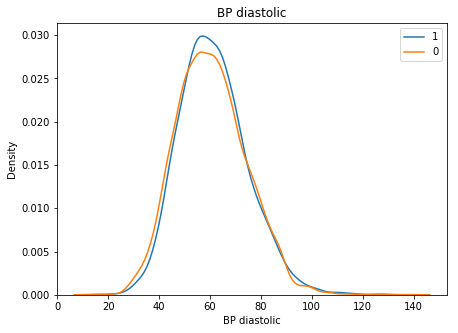

<Figure size 432x288 with 0 Axes>

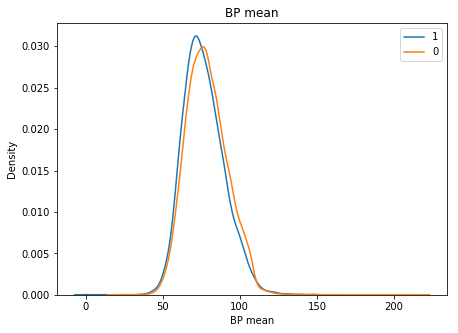

<Figure size 432x288 with 0 Axes>

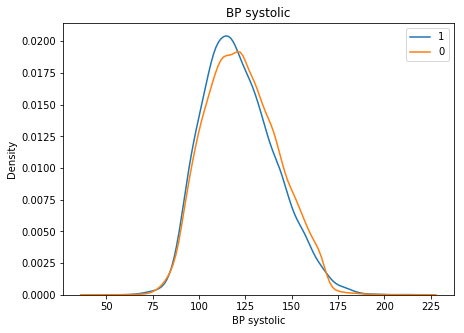

<Figure size 432x288 with 0 Axes>

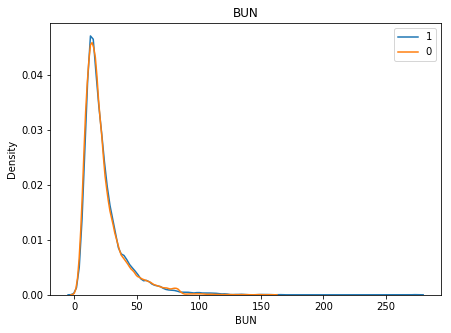

<Figure size 432x288 with 0 Axes>

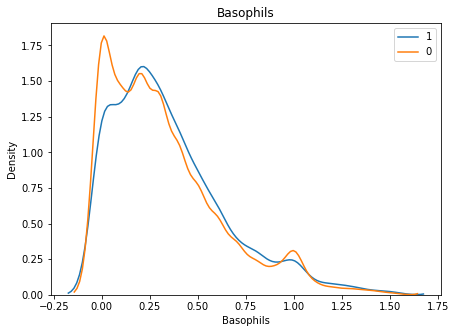

<Figure size 432x288 with 0 Axes>

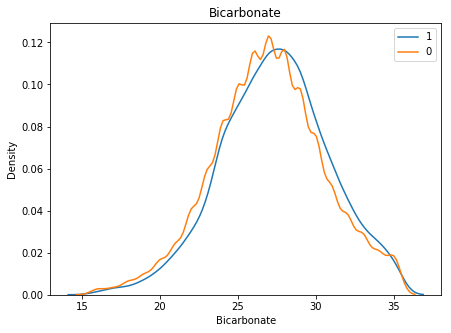

<Figure size 432x288 with 0 Axes>

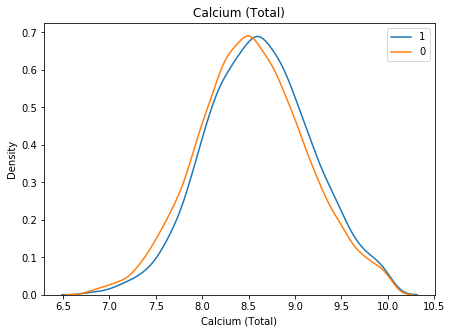

<Figure size 432x288 with 0 Axes>

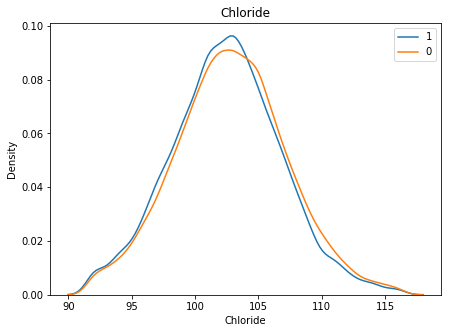

<Figure size 432x288 with 0 Axes>

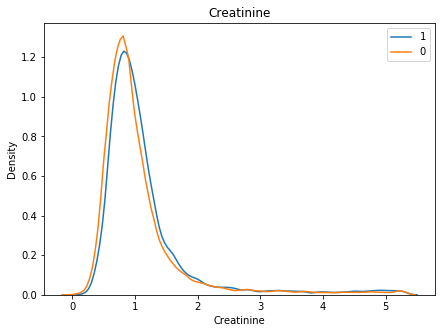

<Figure size 432x288 with 0 Axes>

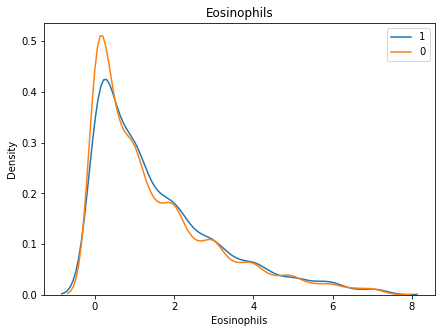

<Figure size 432x288 with 0 Axes>

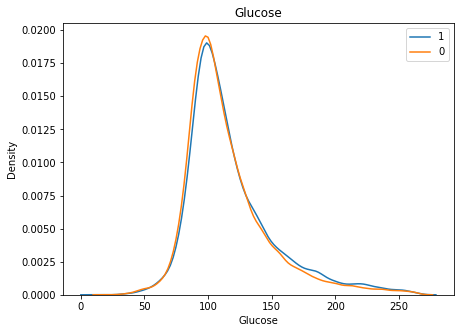

<Figure size 432x288 with 0 Axes>

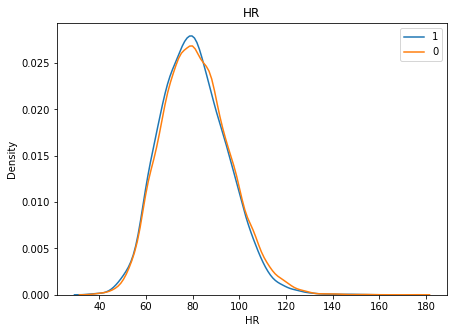

<Figure size 432x288 with 0 Axes>

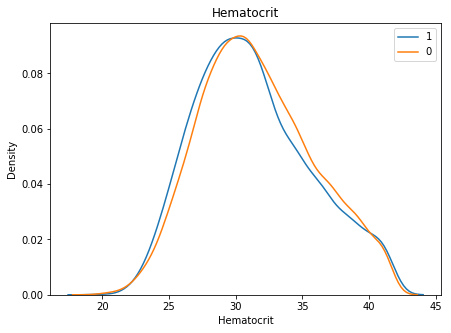

<Figure size 432x288 with 0 Axes>

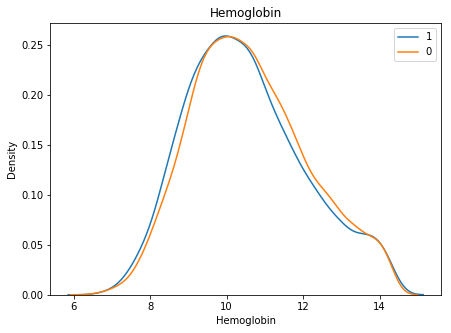

<Figure size 432x288 with 0 Axes>

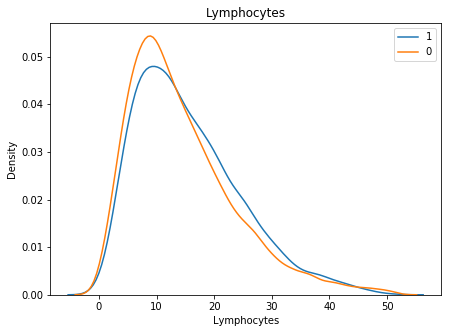

<Figure size 432x288 with 0 Axes>

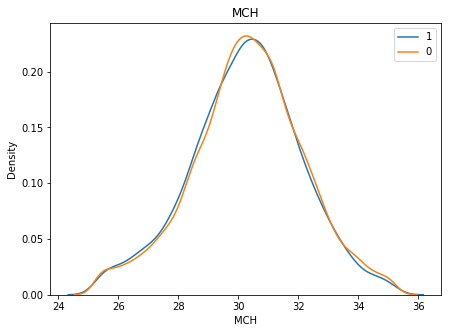

<Figure size 432x288 with 0 Axes>

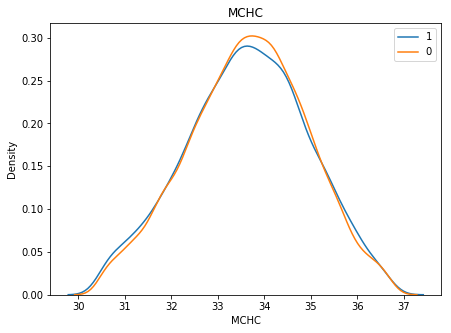

<Figure size 432x288 with 0 Axes>

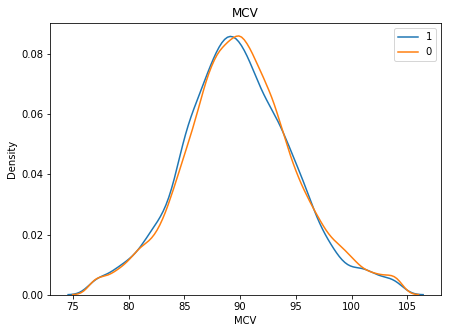

<Figure size 432x288 with 0 Axes>

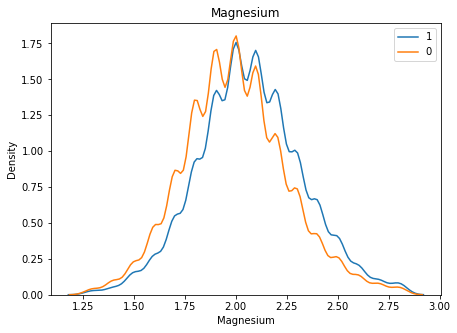

<Figure size 432x288 with 0 Axes>

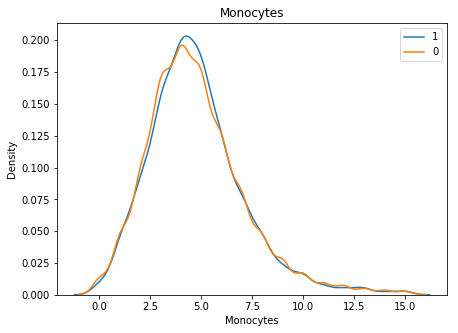

<Figure size 432x288 with 0 Axes>

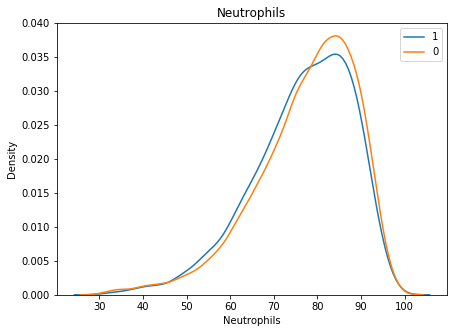

<Figure size 432x288 with 0 Axes>

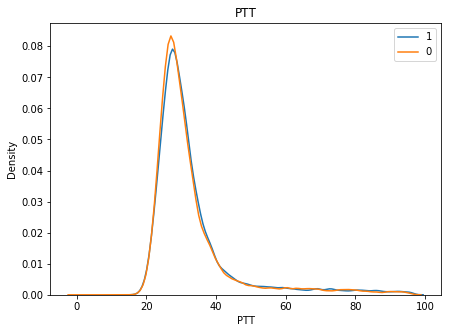

<Figure size 432x288 with 0 Axes>

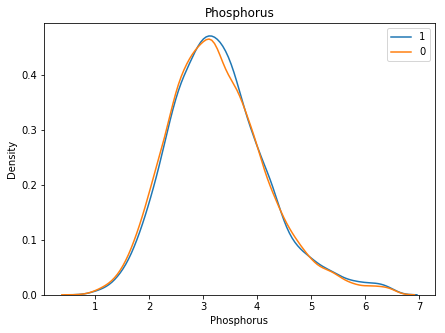

<Figure size 432x288 with 0 Axes>

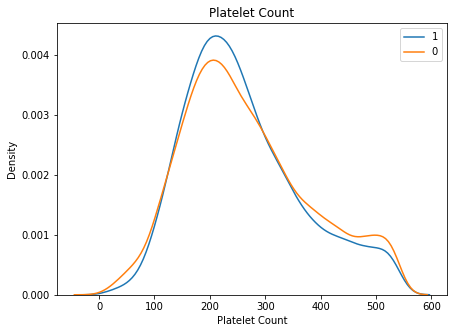

<Figure size 432x288 with 0 Axes>

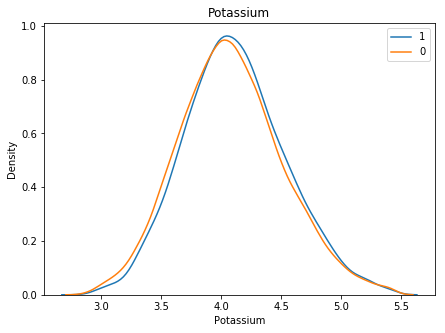

<Figure size 432x288 with 0 Axes>

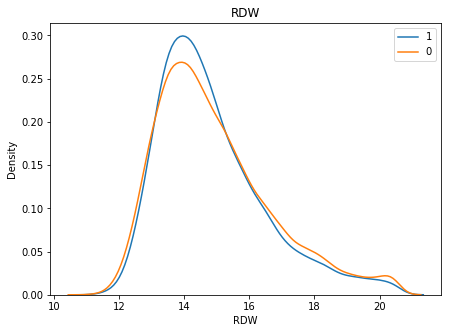

<Figure size 432x288 with 0 Axes>

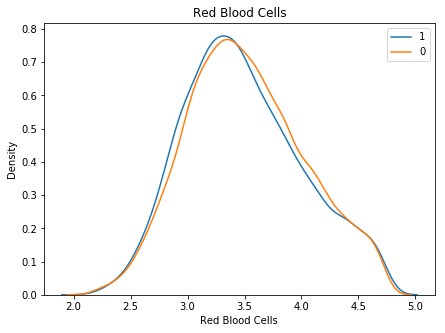

<Figure size 432x288 with 0 Axes>

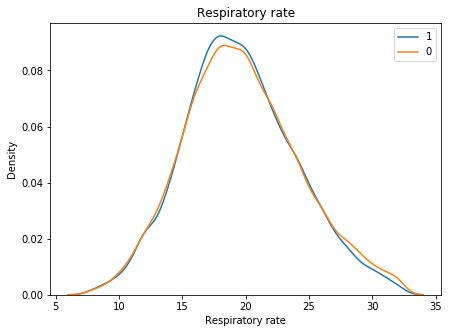

<Figure size 432x288 with 0 Axes>

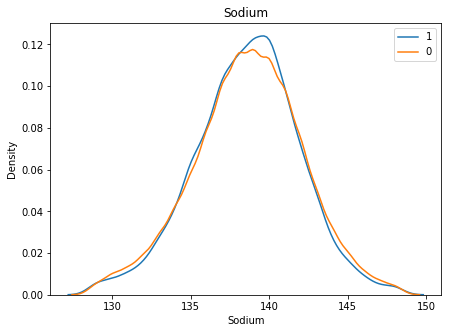

<Figure size 432x288 with 0 Axes>

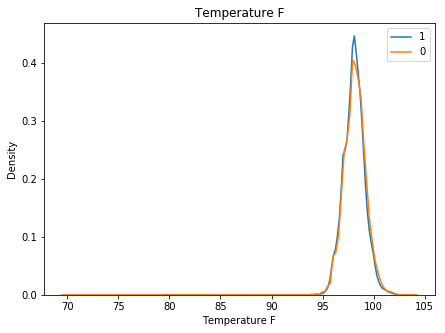

<Figure size 432x288 with 0 Axes>

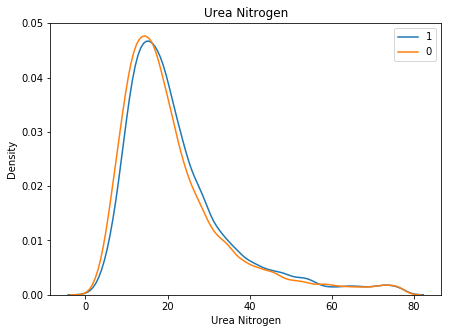

<Figure size 432x288 with 0 Axes>

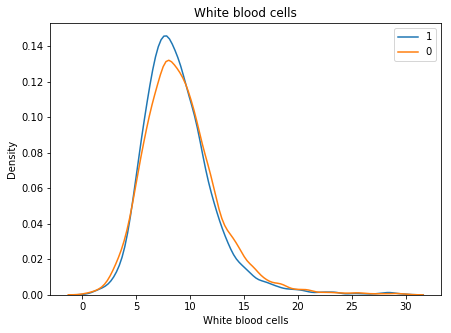

<Figure size 432x288 with 0 Axes>

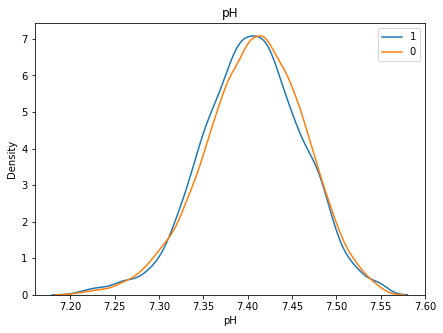

--> Training set counts:  
 0    14081
1     5559
Name: target, dtype: int64
--> Test set counts:  
 0    3554
1    1357
Name: target, dtype: int64
anemia
--> Original base group size:  29726
--> Sampled base group size:  20400
--> Subject group size:  4525


<Figure size 432x288 with 0 Axes>

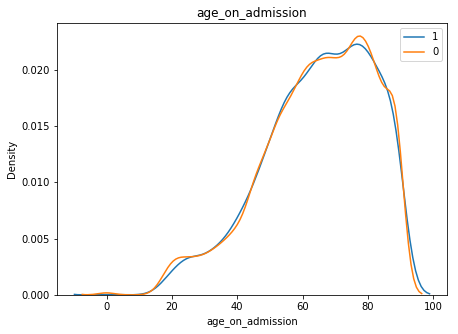

<Figure size 432x288 with 0 Axes>

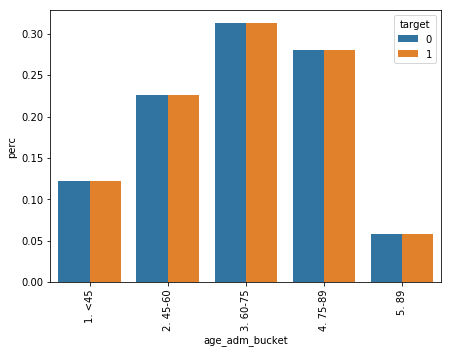

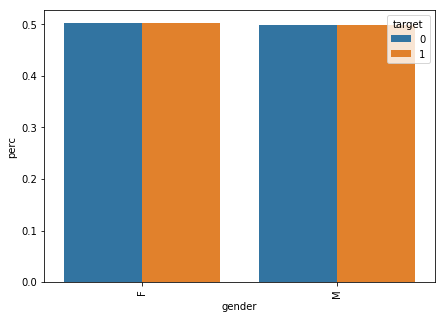

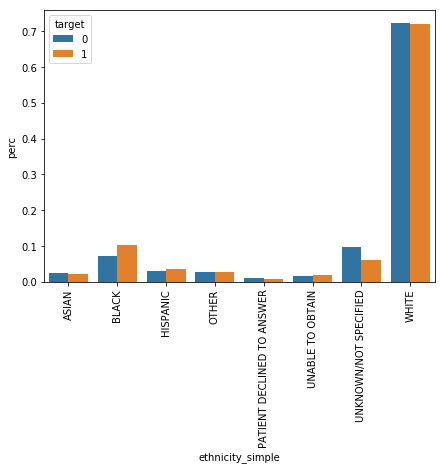

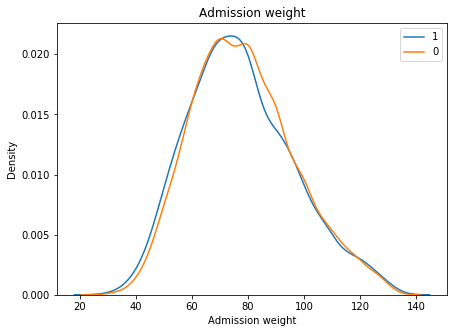

<Figure size 432x288 with 0 Axes>

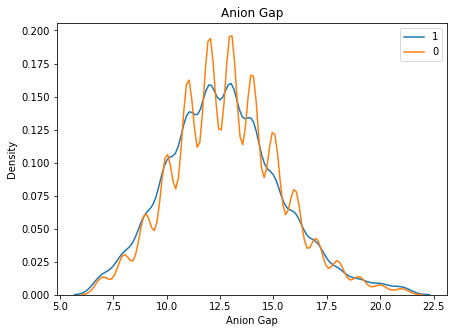

<Figure size 432x288 with 0 Axes>

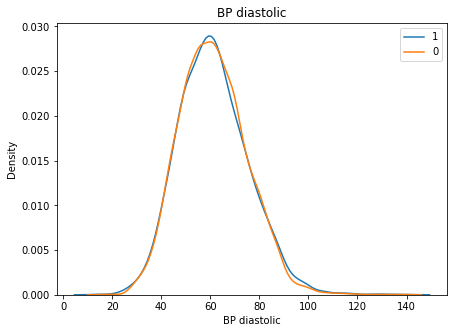

<Figure size 432x288 with 0 Axes>

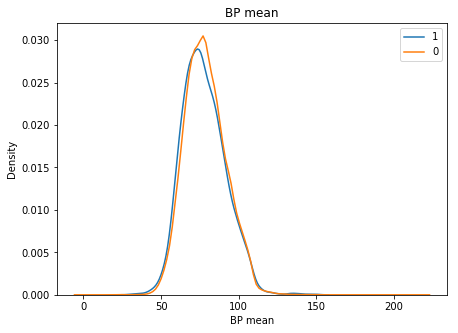

<Figure size 432x288 with 0 Axes>

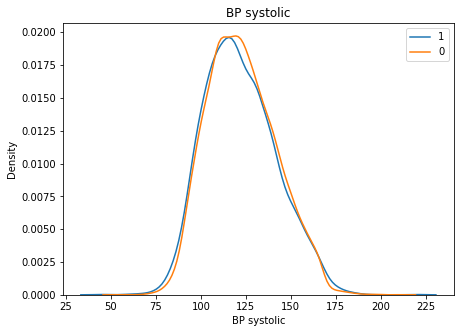

<Figure size 432x288 with 0 Axes>

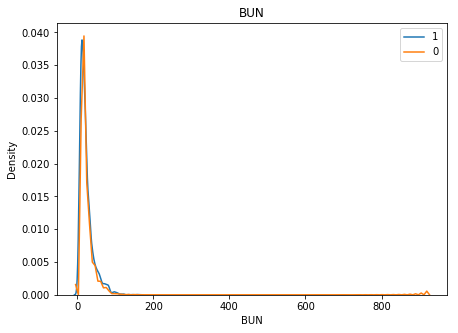

<Figure size 432x288 with 0 Axes>

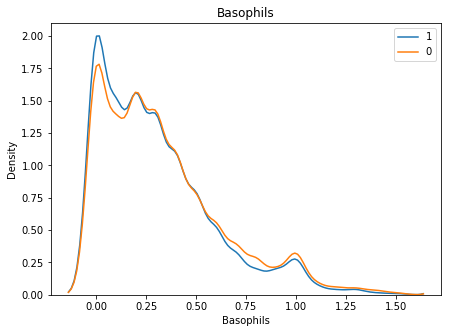

<Figure size 432x288 with 0 Axes>

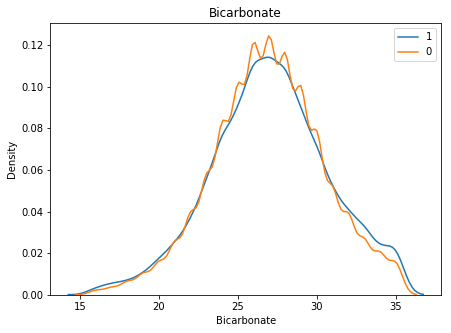

<Figure size 432x288 with 0 Axes>

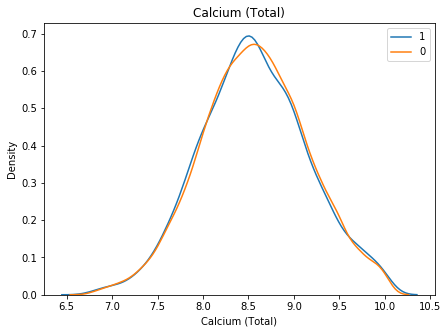

<Figure size 432x288 with 0 Axes>

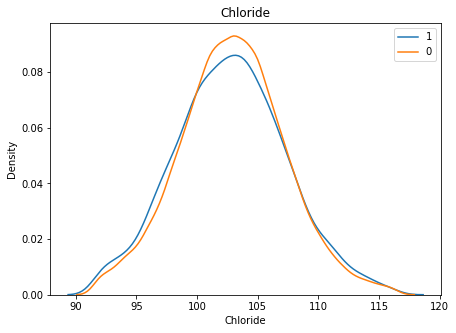

<Figure size 432x288 with 0 Axes>

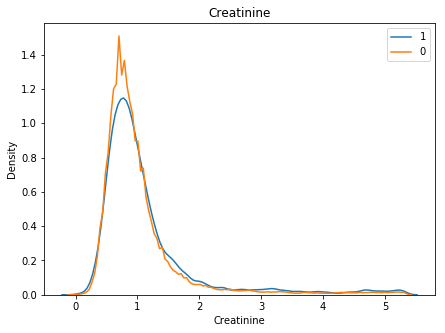

<Figure size 432x288 with 0 Axes>

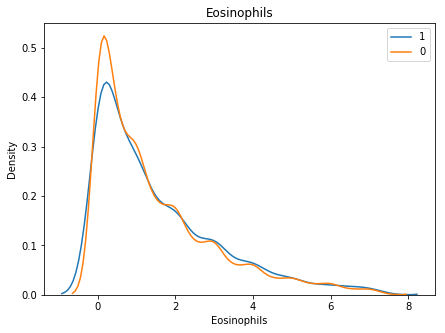

<Figure size 432x288 with 0 Axes>

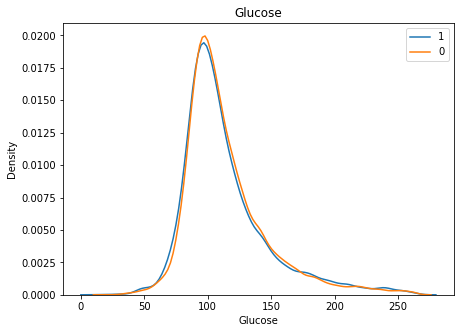

<Figure size 432x288 with 0 Axes>

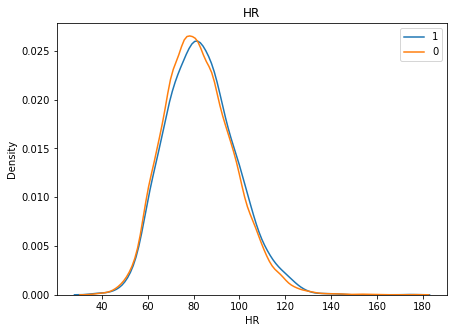

<Figure size 432x288 with 0 Axes>

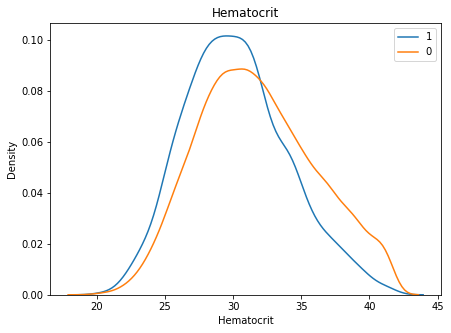

<Figure size 432x288 with 0 Axes>

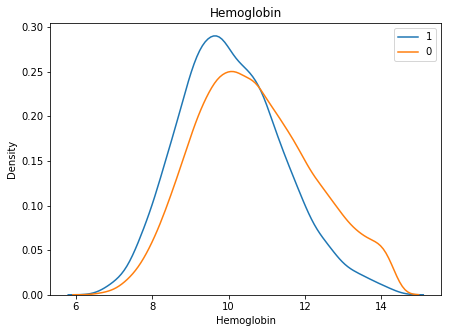

<Figure size 432x288 with 0 Axes>

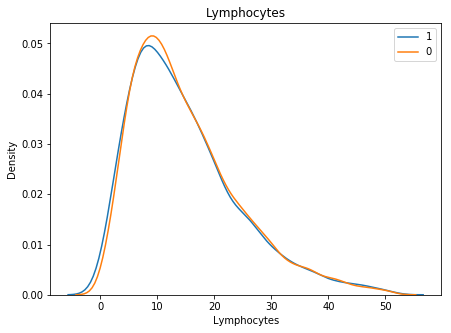

<Figure size 432x288 with 0 Axes>

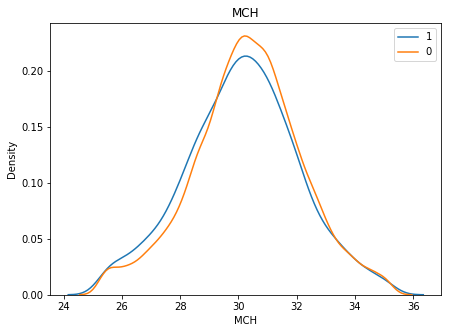

<Figure size 432x288 with 0 Axes>

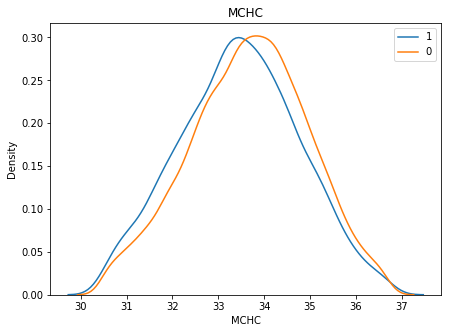

<Figure size 432x288 with 0 Axes>

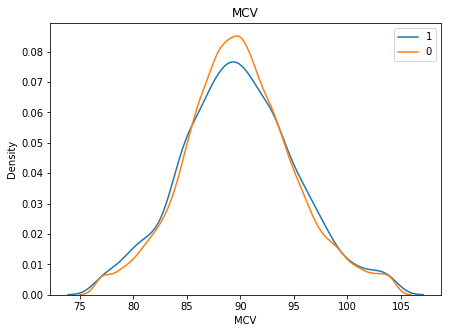

<Figure size 432x288 with 0 Axes>

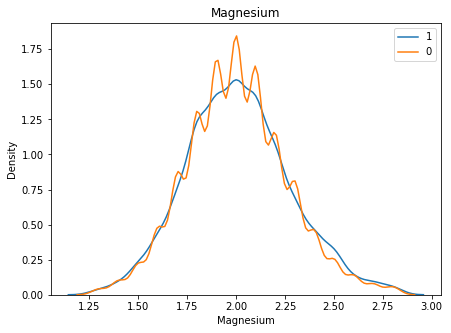

<Figure size 432x288 with 0 Axes>

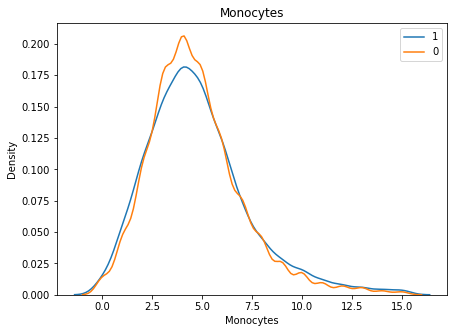

<Figure size 432x288 with 0 Axes>

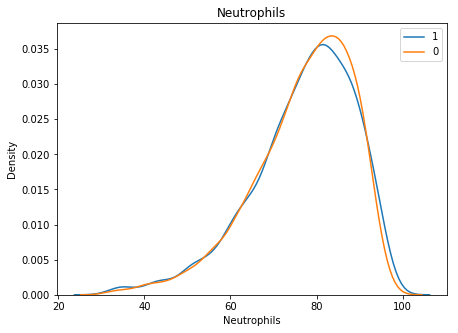

<Figure size 432x288 with 0 Axes>

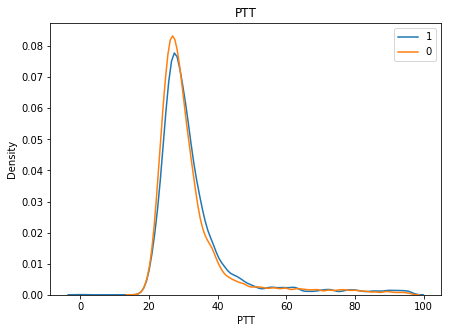

<Figure size 432x288 with 0 Axes>

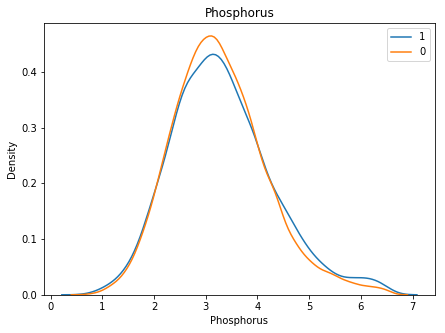

<Figure size 432x288 with 0 Axes>

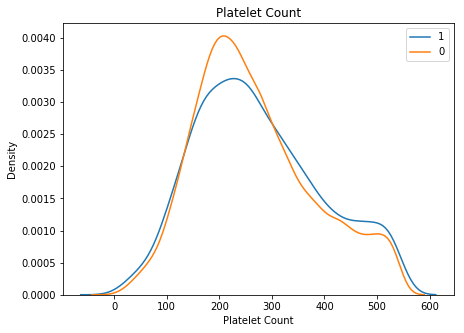

<Figure size 432x288 with 0 Axes>

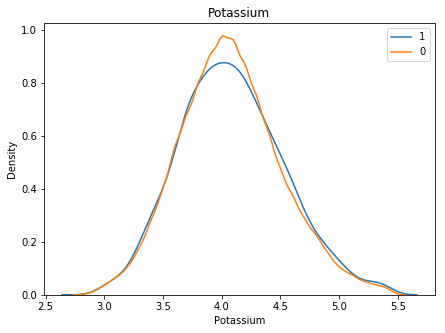

<Figure size 432x288 with 0 Axes>

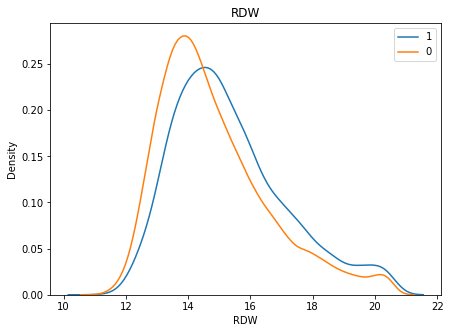

<Figure size 432x288 with 0 Axes>

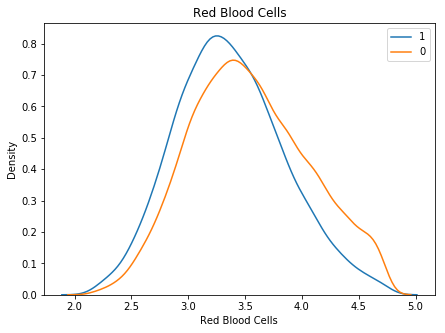

<Figure size 432x288 with 0 Axes>

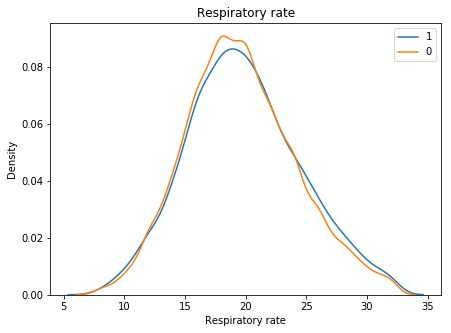

<Figure size 432x288 with 0 Axes>

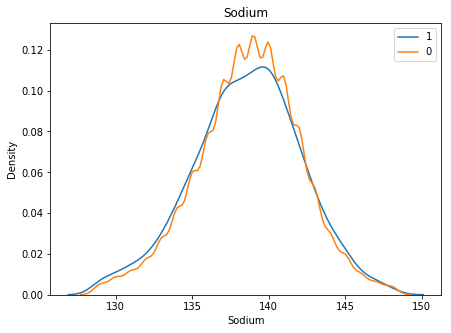

<Figure size 432x288 with 0 Axes>

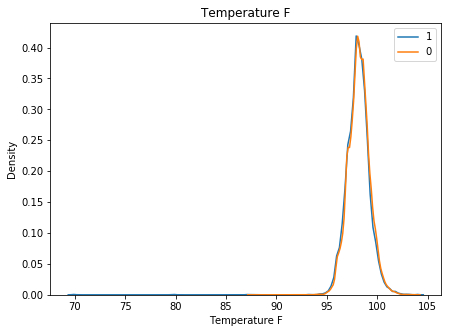

<Figure size 432x288 with 0 Axes>

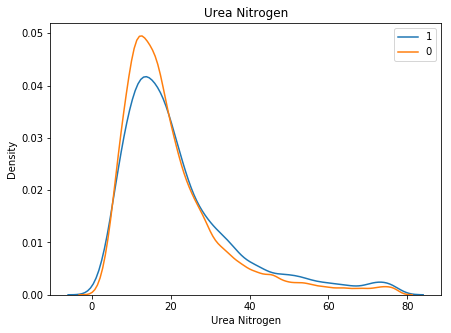

<Figure size 432x288 with 0 Axes>

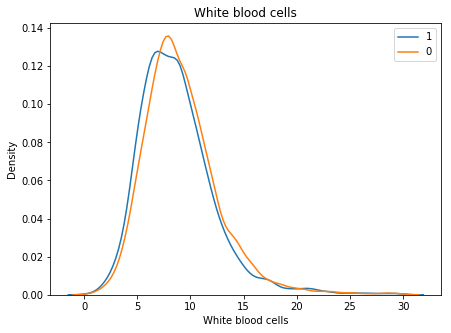

<Figure size 432x288 with 0 Axes>

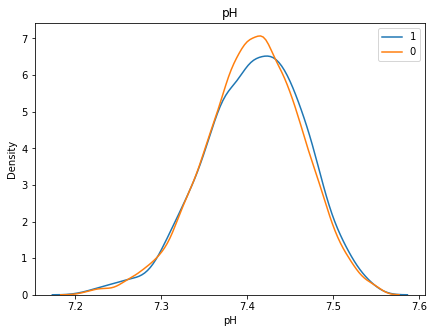

--> Training set counts:  
 0    16336
1     3604
Name: target, dtype: int64
--> Test set counts:  
 0    4064
1     921
Name: target, dtype: int64
pneumonia
--> Original base group size:  30645
--> Sampled base group size:  15976
--> Subject group size:  3504


<Figure size 432x288 with 0 Axes>

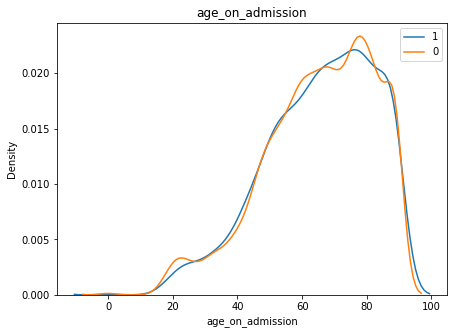

<Figure size 432x288 with 0 Axes>

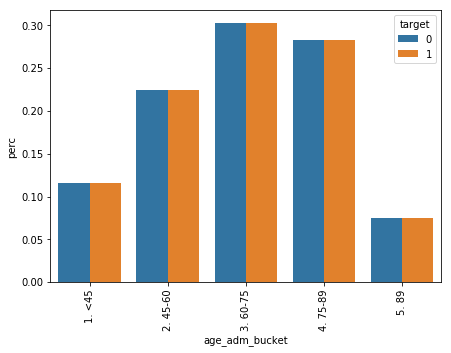

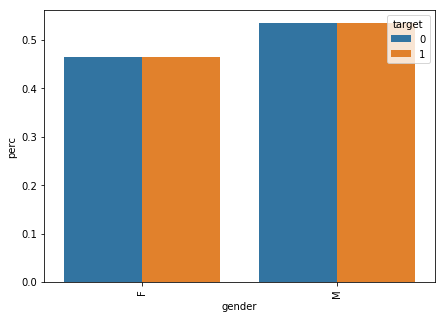

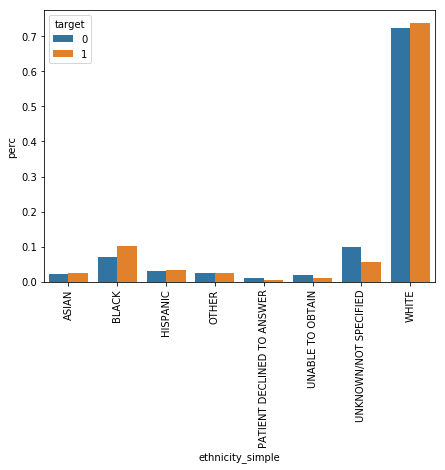

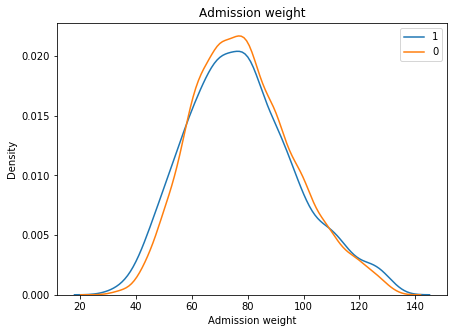

<Figure size 432x288 with 0 Axes>

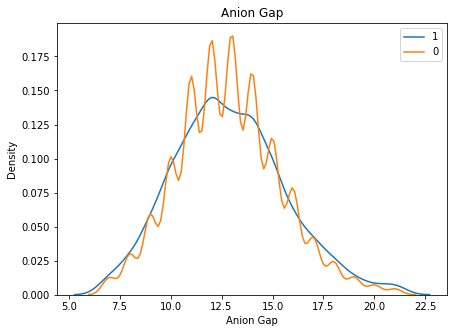

<Figure size 432x288 with 0 Axes>

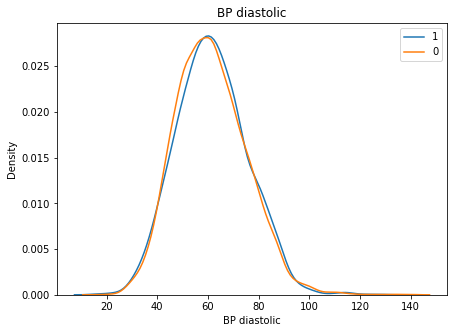

<Figure size 432x288 with 0 Axes>

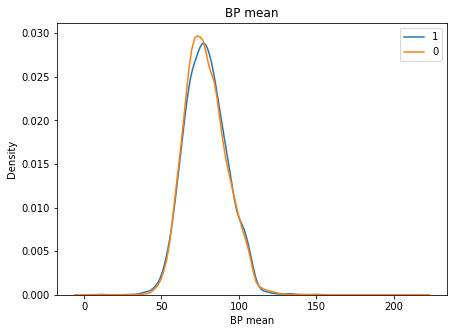

<Figure size 432x288 with 0 Axes>

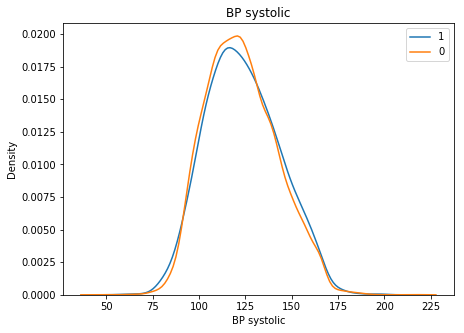

<Figure size 432x288 with 0 Axes>

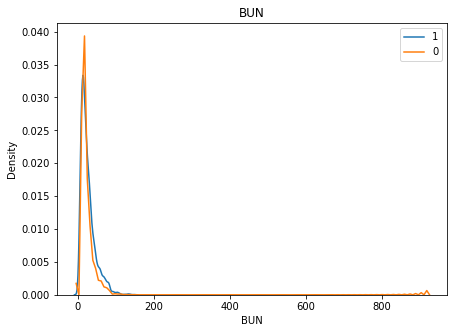

<Figure size 432x288 with 0 Axes>

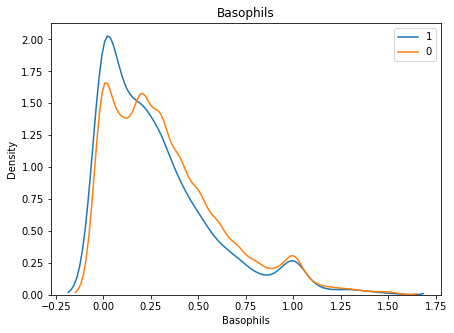

<Figure size 432x288 with 0 Axes>

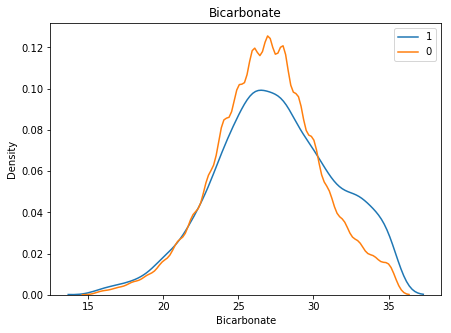

<Figure size 432x288 with 0 Axes>

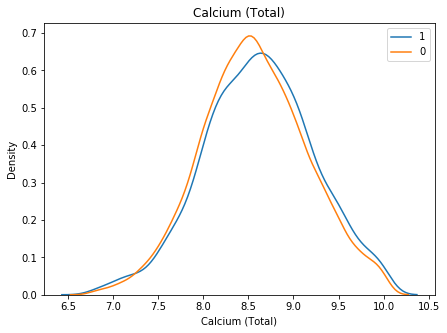

<Figure size 432x288 with 0 Axes>

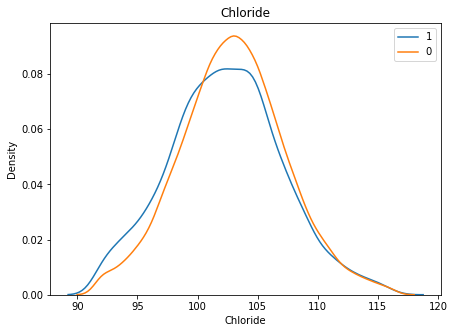

<Figure size 432x288 with 0 Axes>

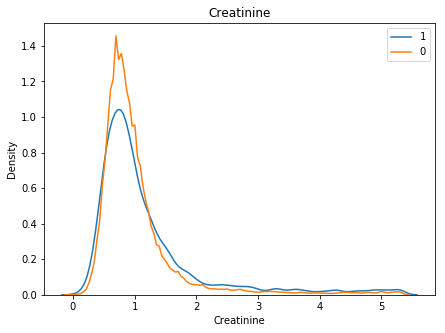

<Figure size 432x288 with 0 Axes>

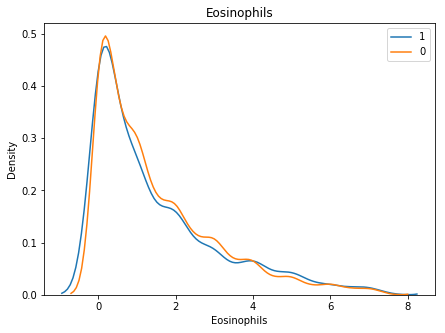

<Figure size 432x288 with 0 Axes>

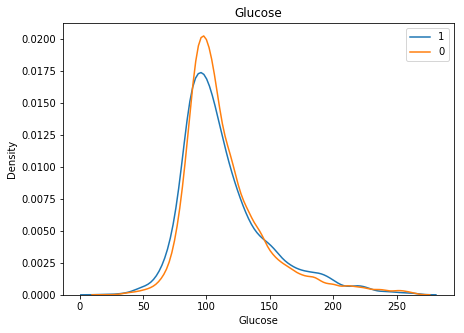

<Figure size 432x288 with 0 Axes>

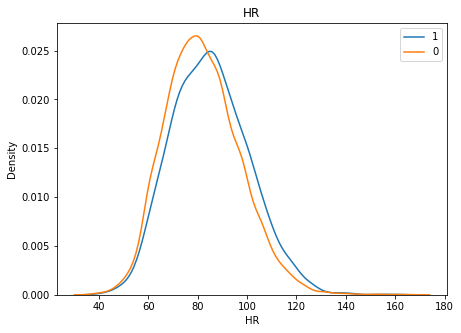

<Figure size 432x288 with 0 Axes>

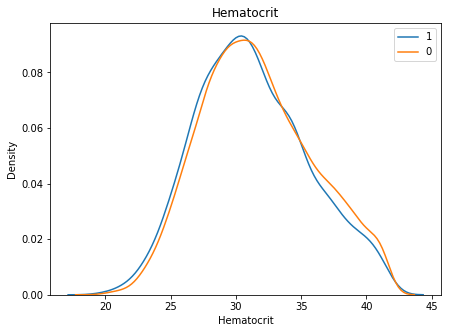

<Figure size 432x288 with 0 Axes>

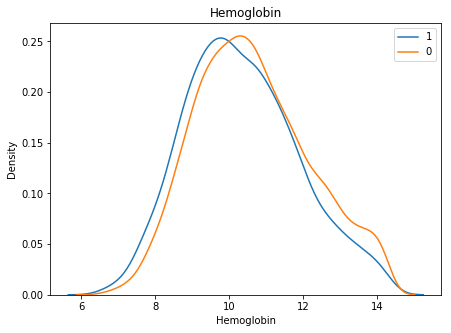

<Figure size 432x288 with 0 Axes>

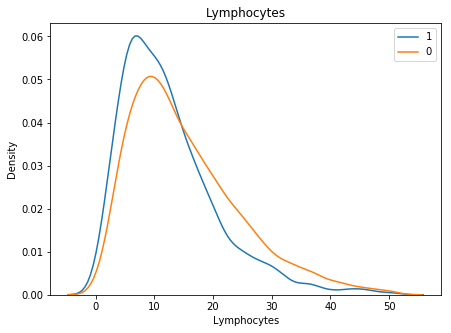

<Figure size 432x288 with 0 Axes>

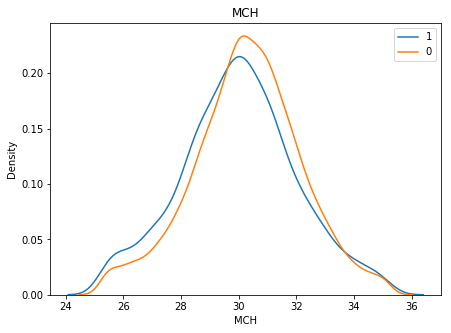

<Figure size 432x288 with 0 Axes>

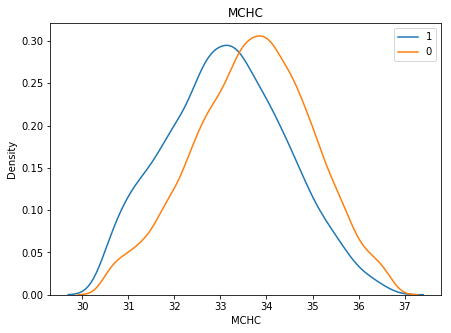

<Figure size 432x288 with 0 Axes>

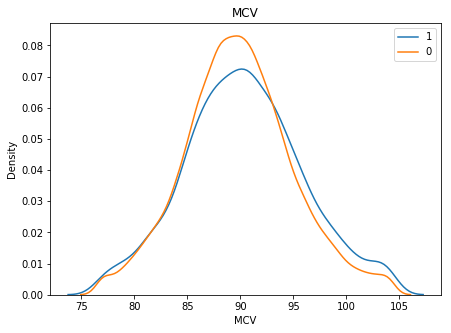

<Figure size 432x288 with 0 Axes>

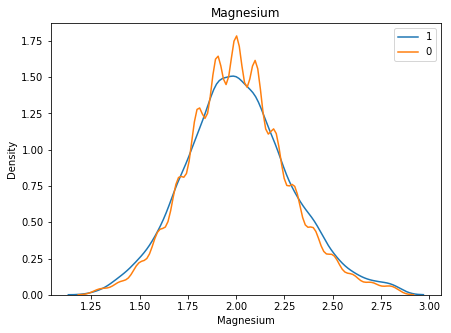

<Figure size 432x288 with 0 Axes>

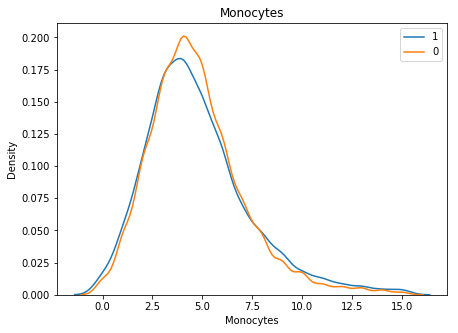

<Figure size 432x288 with 0 Axes>

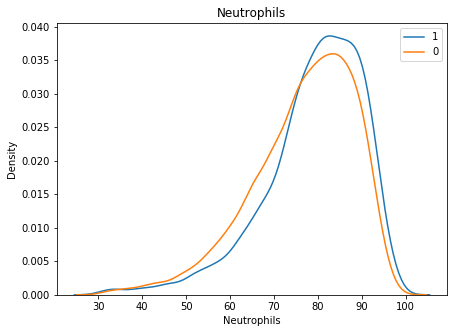

<Figure size 432x288 with 0 Axes>

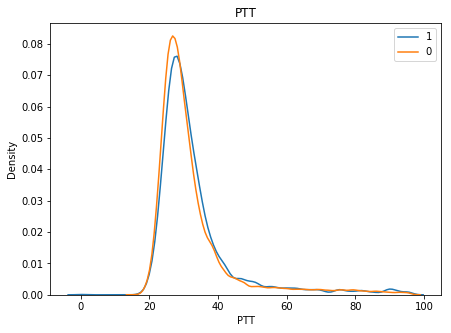

<Figure size 432x288 with 0 Axes>

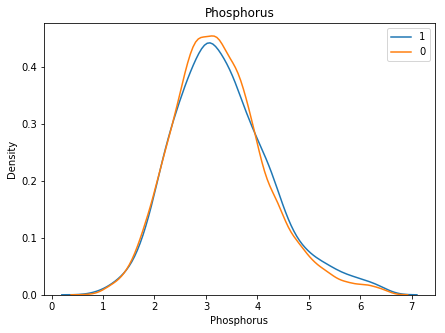

<Figure size 432x288 with 0 Axes>

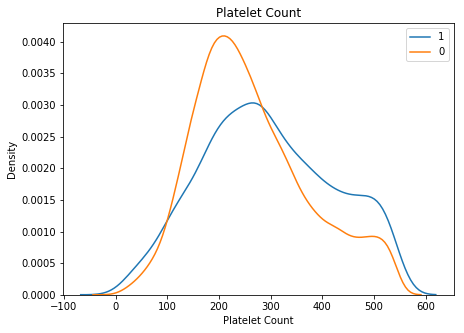

<Figure size 432x288 with 0 Axes>

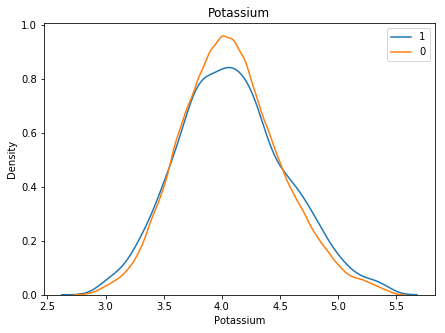

<Figure size 432x288 with 0 Axes>

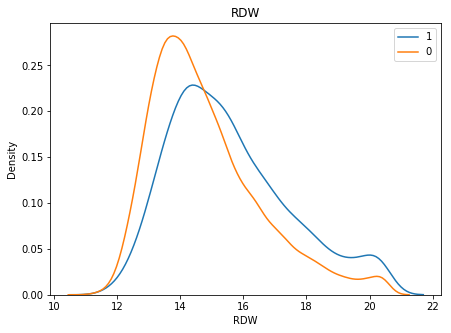

<Figure size 432x288 with 0 Axes>

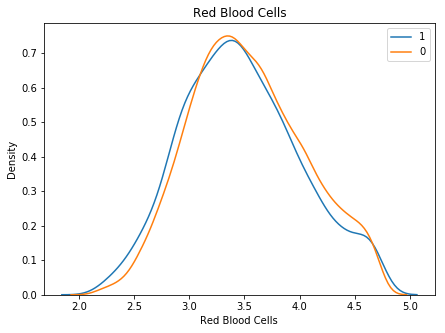

<Figure size 432x288 with 0 Axes>

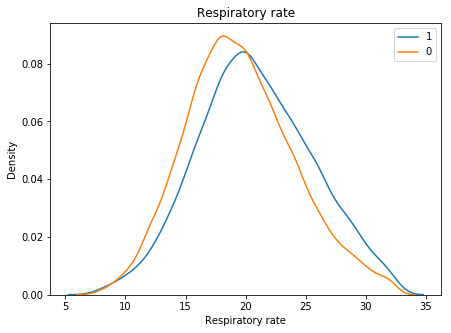

<Figure size 432x288 with 0 Axes>

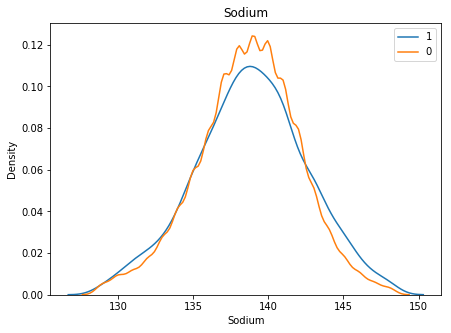

<Figure size 432x288 with 0 Axes>

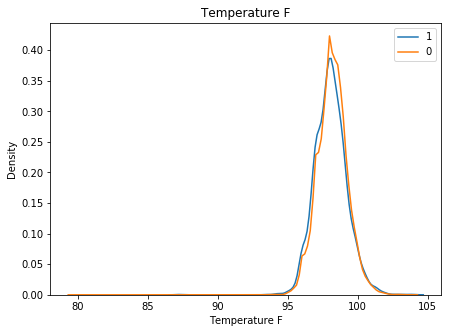

<Figure size 432x288 with 0 Axes>

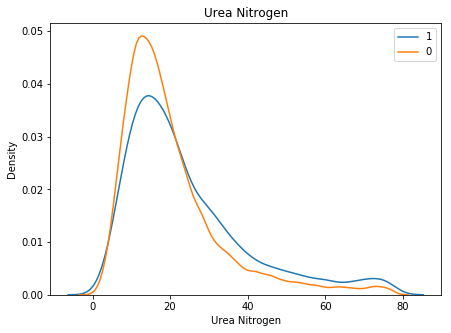

<Figure size 432x288 with 0 Axes>

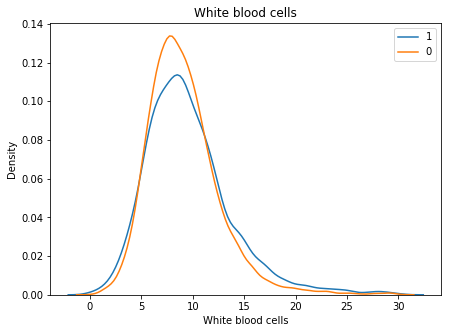

<Figure size 432x288 with 0 Axes>

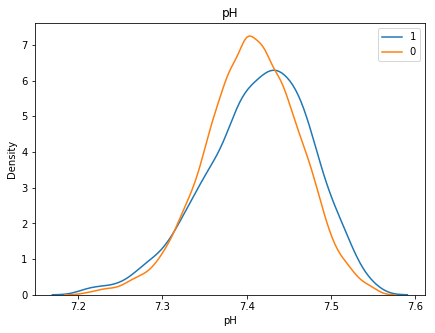

--> Training set counts:  
 0    12785
1     2799
Name: target, dtype: int64
--> Test set counts:  
 0    3191
1     705
Name: target, dtype: int64
depression
--> Original base group size:  31617
--> Sampled base group size:  18792
--> Subject group size:  2700


<Figure size 432x288 with 0 Axes>

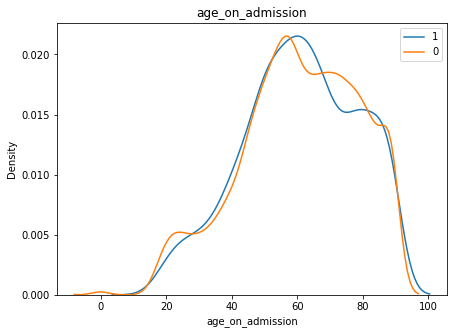

<Figure size 432x288 with 0 Axes>

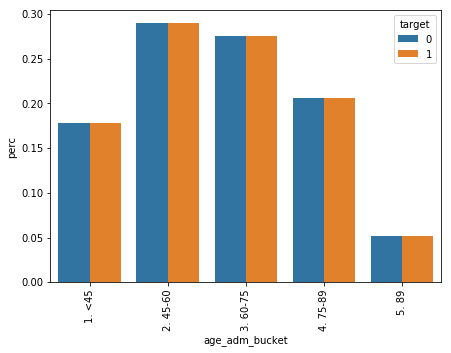

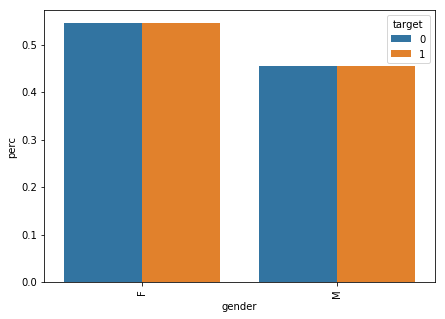

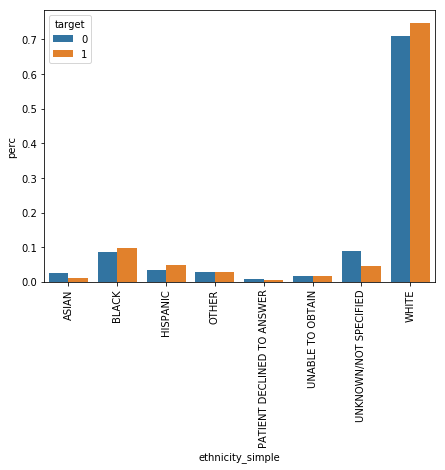

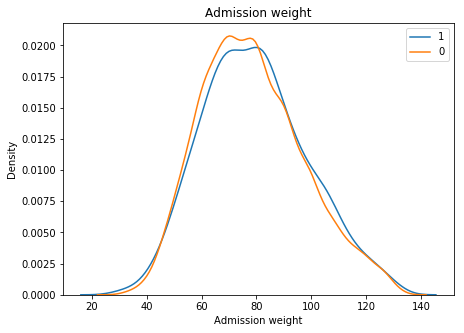

<Figure size 432x288 with 0 Axes>

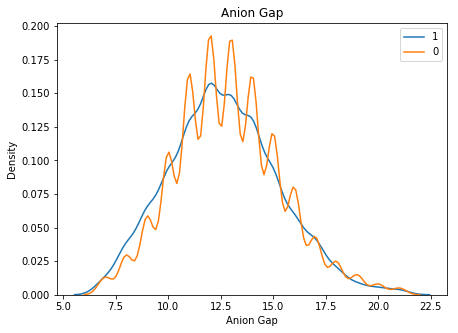

<Figure size 432x288 with 0 Axes>

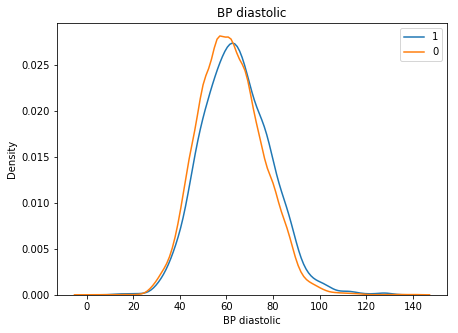

<Figure size 432x288 with 0 Axes>

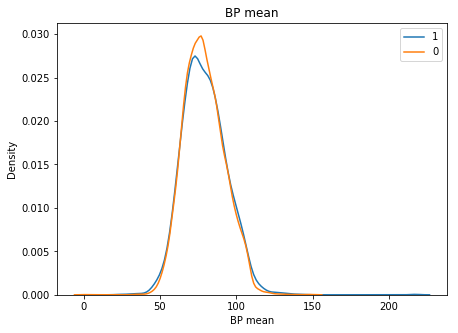

<Figure size 432x288 with 0 Axes>

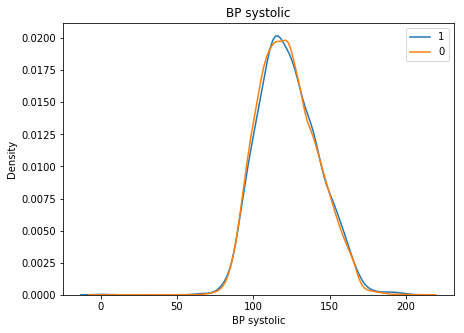

<Figure size 432x288 with 0 Axes>

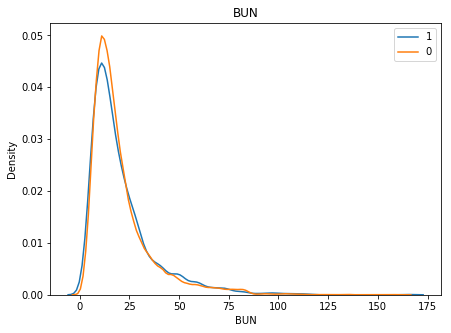

<Figure size 432x288 with 0 Axes>

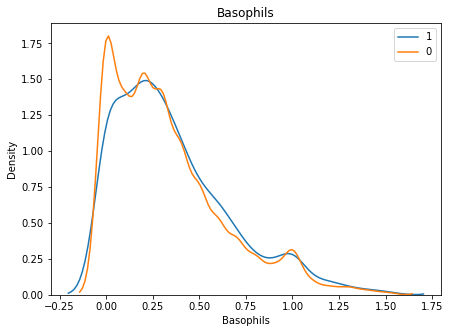

<Figure size 432x288 with 0 Axes>

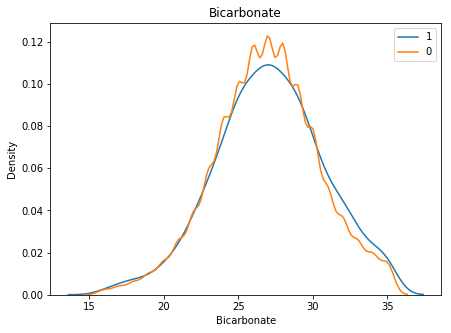

<Figure size 432x288 with 0 Axes>

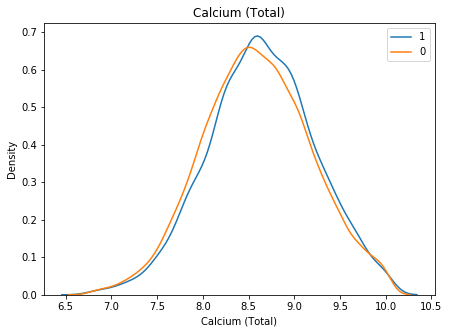

<Figure size 432x288 with 0 Axes>

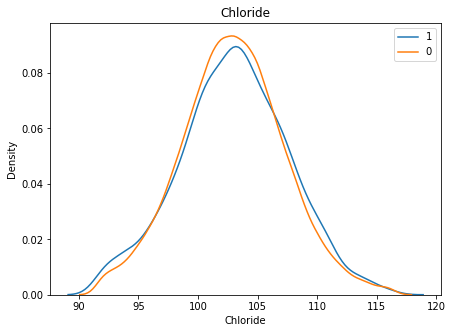

<Figure size 432x288 with 0 Axes>

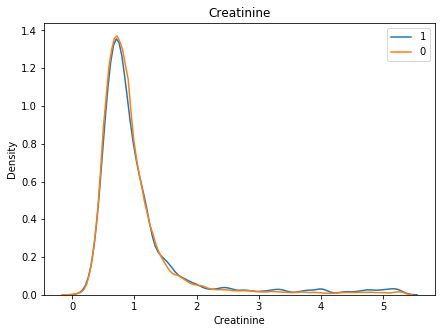

<Figure size 432x288 with 0 Axes>

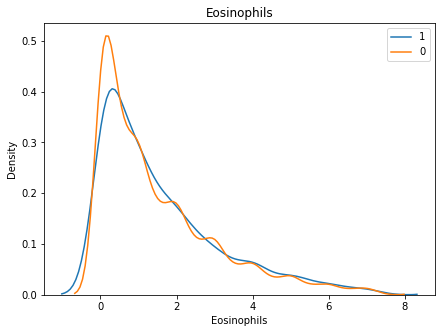

<Figure size 432x288 with 0 Axes>

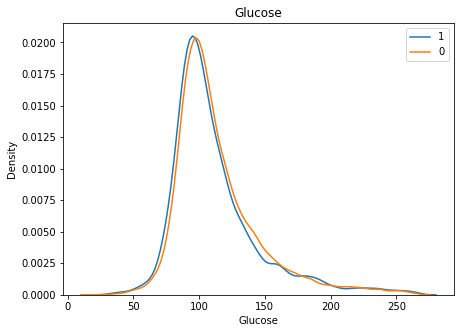

<Figure size 432x288 with 0 Axes>

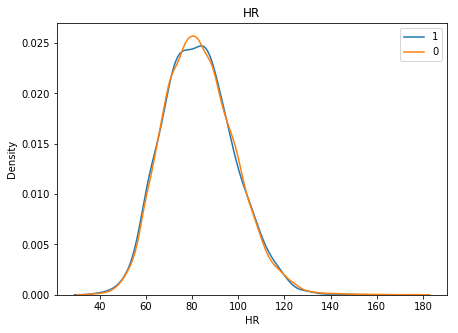

<Figure size 432x288 with 0 Axes>

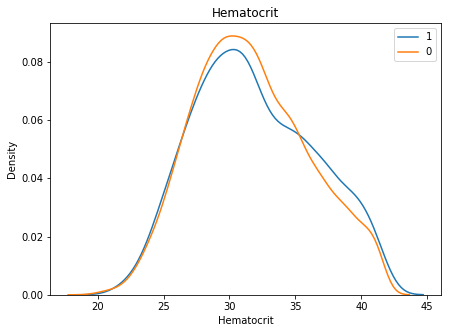

<Figure size 432x288 with 0 Axes>

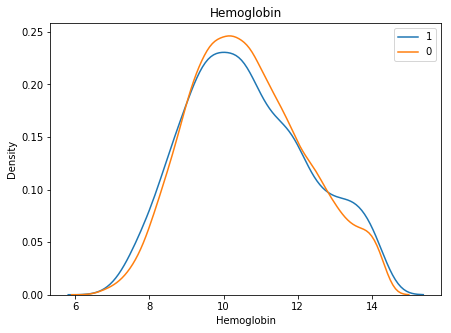

<Figure size 432x288 with 0 Axes>

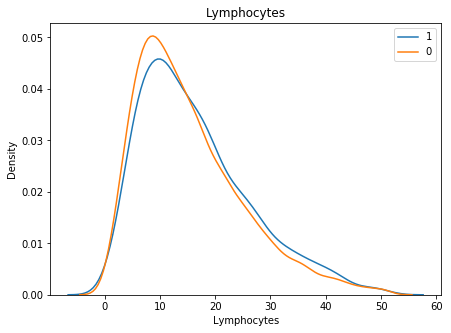

<Figure size 432x288 with 0 Axes>

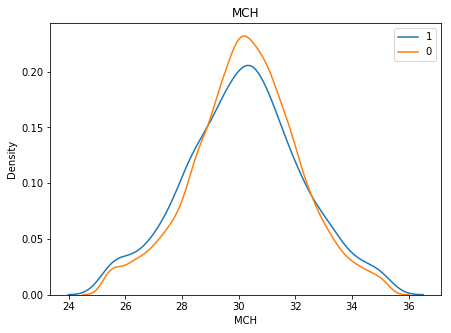

<Figure size 432x288 with 0 Axes>

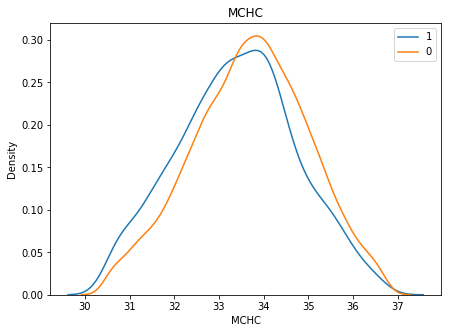

<Figure size 432x288 with 0 Axes>

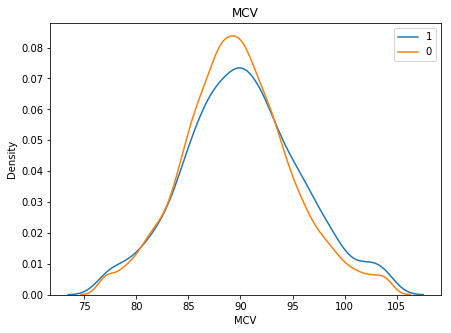

<Figure size 432x288 with 0 Axes>

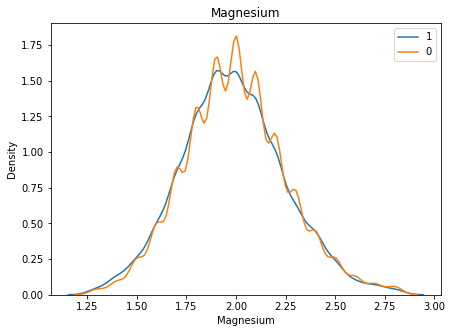

<Figure size 432x288 with 0 Axes>

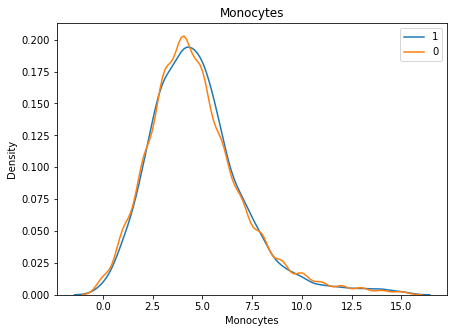

<Figure size 432x288 with 0 Axes>

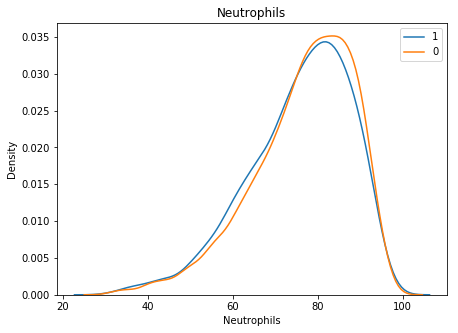

<Figure size 432x288 with 0 Axes>

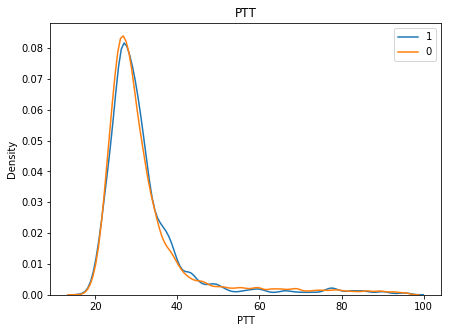

<Figure size 432x288 with 0 Axes>

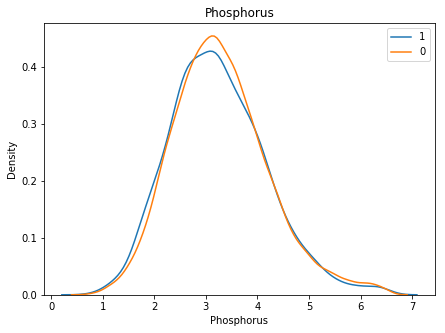

<Figure size 432x288 with 0 Axes>

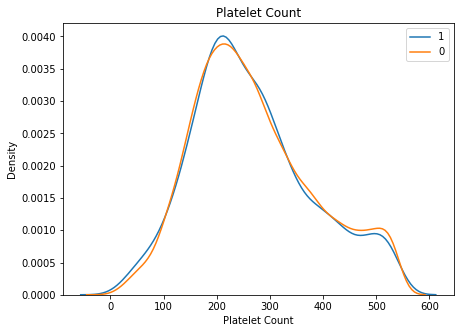

<Figure size 432x288 with 0 Axes>

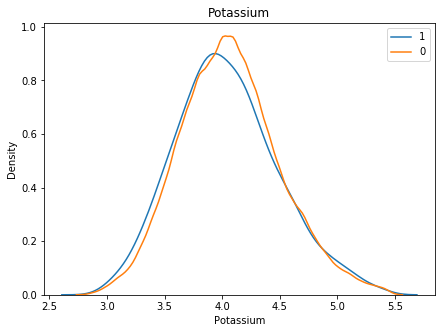

<Figure size 432x288 with 0 Axes>

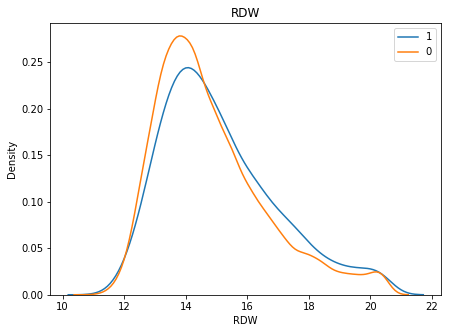

<Figure size 432x288 with 0 Axes>

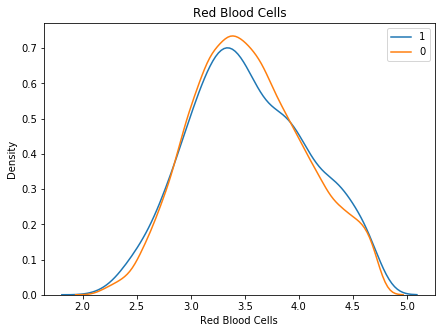

<Figure size 432x288 with 0 Axes>

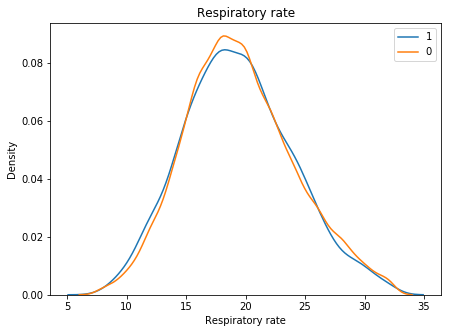

<Figure size 432x288 with 0 Axes>

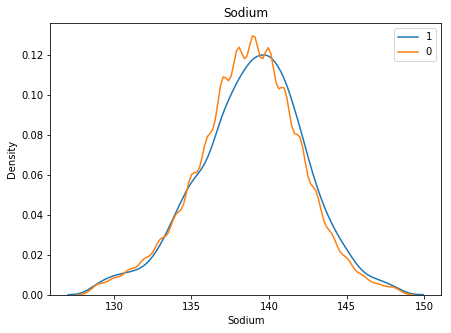

<Figure size 432x288 with 0 Axes>

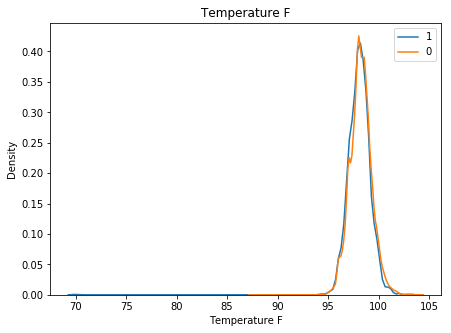

<Figure size 432x288 with 0 Axes>

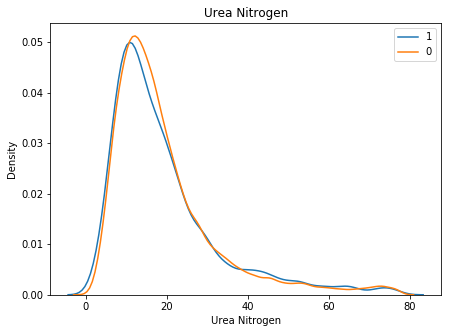

<Figure size 432x288 with 0 Axes>

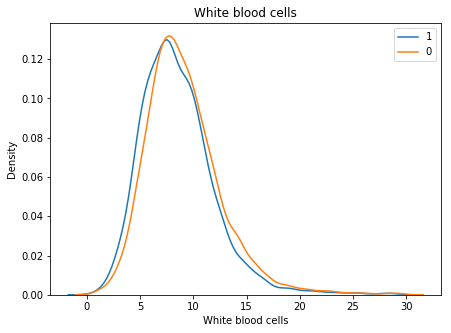

<Figure size 432x288 with 0 Axes>

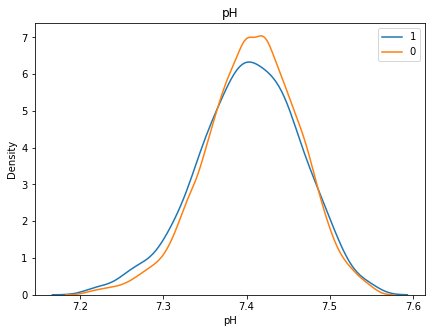

--> Training set counts:  
 0    15038
1     2155
Name: target, dtype: int64
--> Test set counts:  
 0    3754
1     545
Name: target, dtype: int64
chronic_kidney_disease
--> Original base group size:  31743
--> Sampled base group size:  7752
--> Subject group size:  2517


<Figure size 432x288 with 0 Axes>

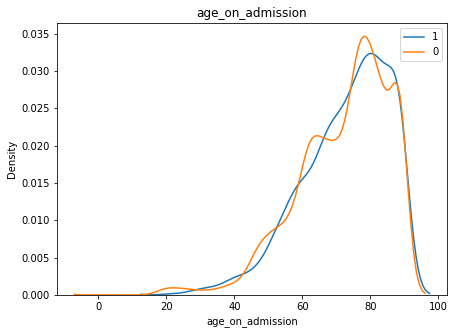

<Figure size 432x288 with 0 Axes>

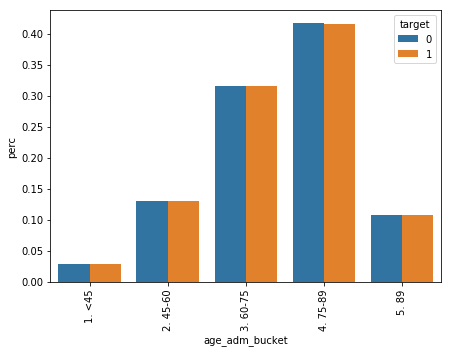

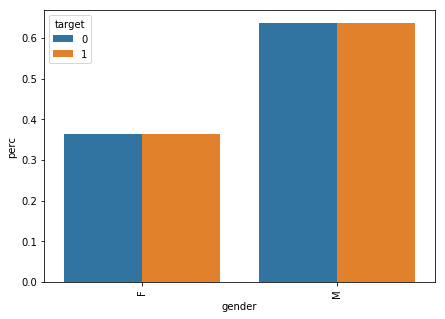

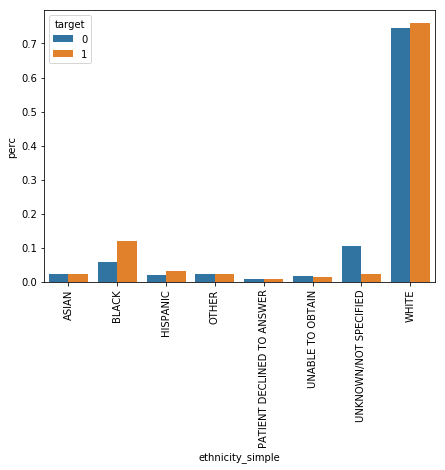

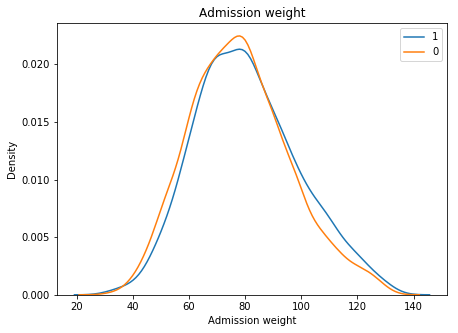

<Figure size 432x288 with 0 Axes>

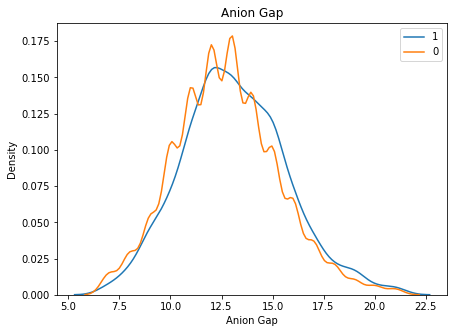

<Figure size 432x288 with 0 Axes>

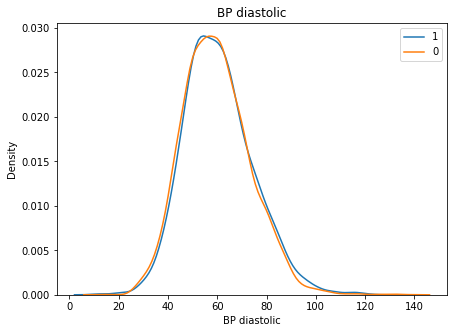

<Figure size 432x288 with 0 Axes>

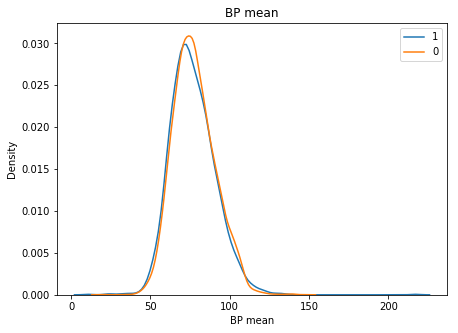

<Figure size 432x288 with 0 Axes>

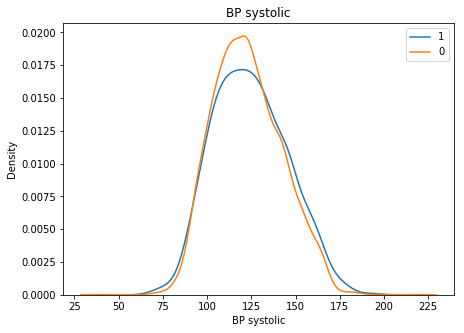

<Figure size 432x288 with 0 Axes>

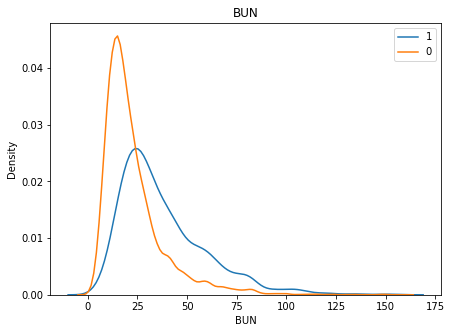

<Figure size 432x288 with 0 Axes>

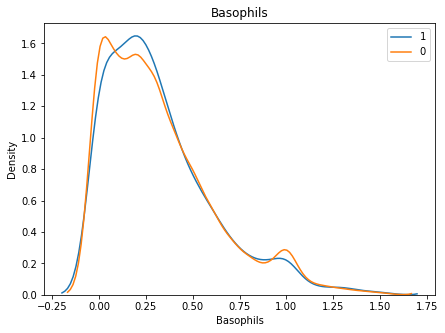

<Figure size 432x288 with 0 Axes>

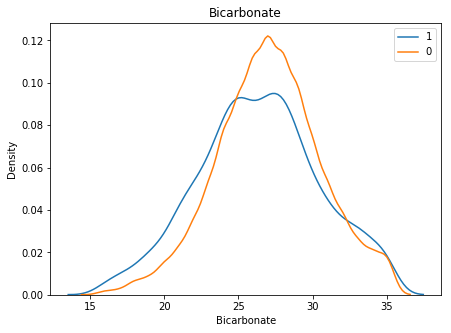

<Figure size 432x288 with 0 Axes>

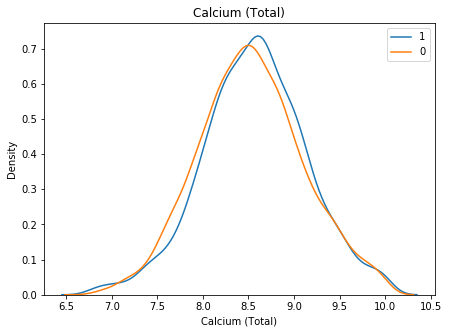

<Figure size 432x288 with 0 Axes>

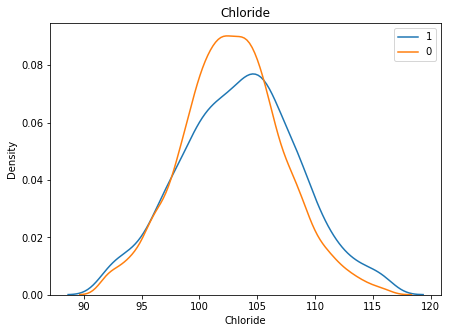

<Figure size 432x288 with 0 Axes>

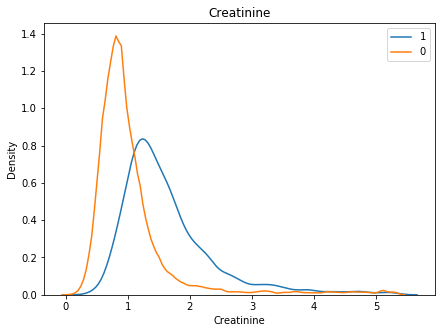

<Figure size 432x288 with 0 Axes>

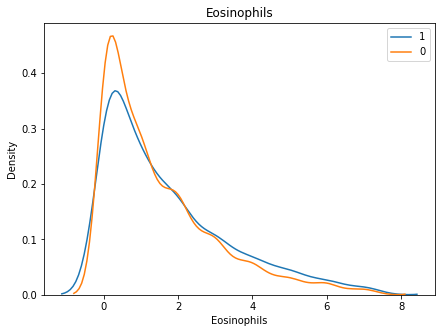

<Figure size 432x288 with 0 Axes>

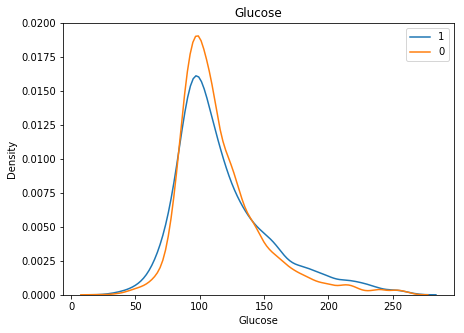

<Figure size 432x288 with 0 Axes>

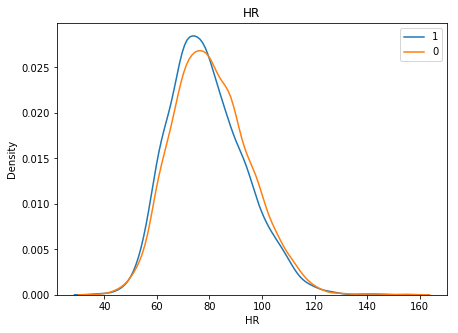

<Figure size 432x288 with 0 Axes>

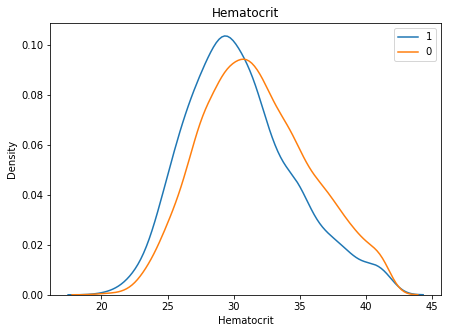

<Figure size 432x288 with 0 Axes>

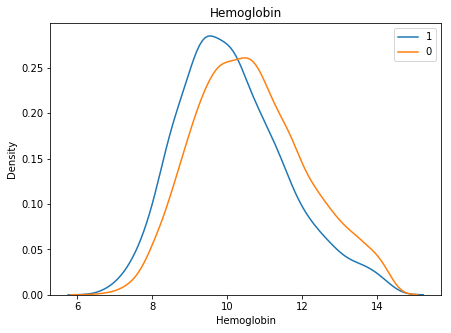

<Figure size 432x288 with 0 Axes>

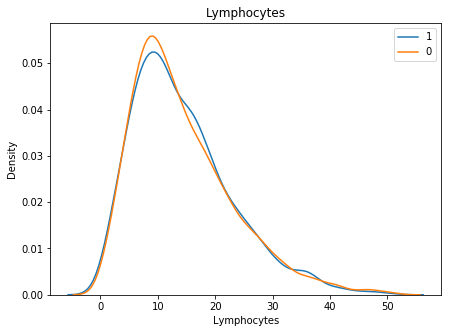

<Figure size 432x288 with 0 Axes>

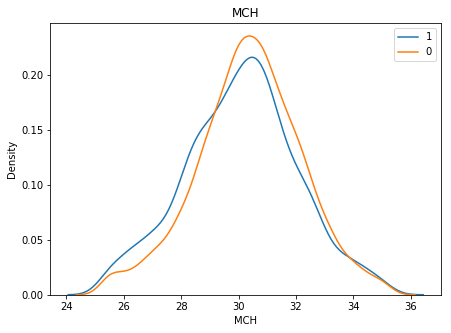

<Figure size 432x288 with 0 Axes>

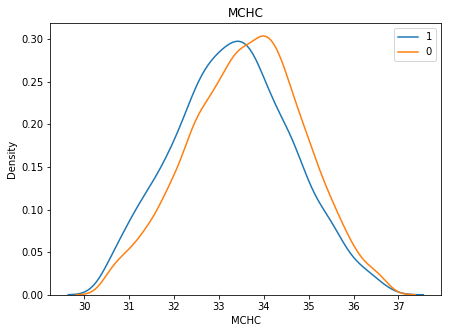

<Figure size 432x288 with 0 Axes>

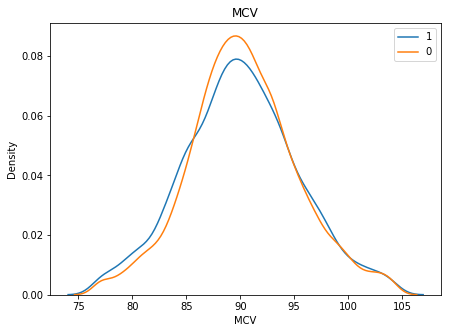

<Figure size 432x288 with 0 Axes>

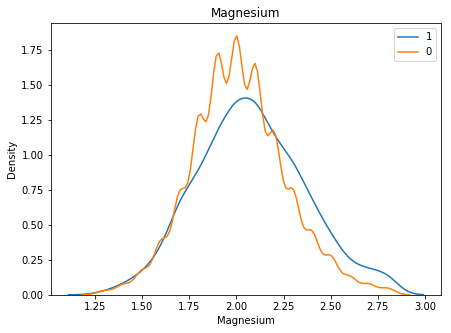

<Figure size 432x288 with 0 Axes>

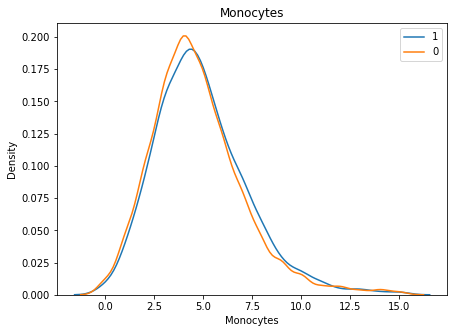

<Figure size 432x288 with 0 Axes>

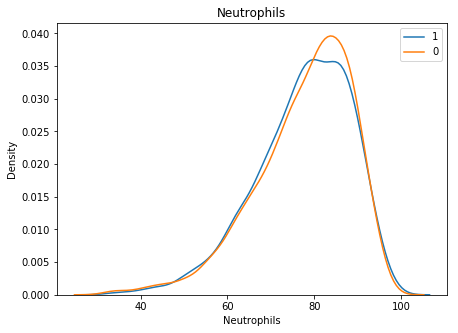

<Figure size 432x288 with 0 Axes>

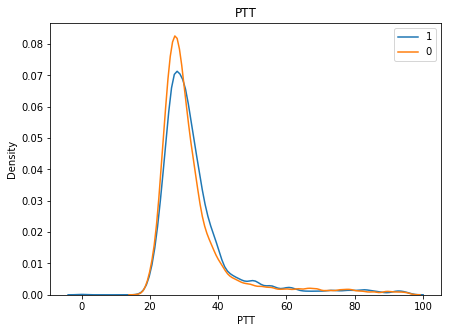

<Figure size 432x288 with 0 Axes>

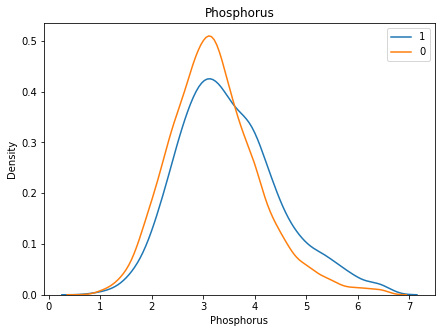

<Figure size 432x288 with 0 Axes>

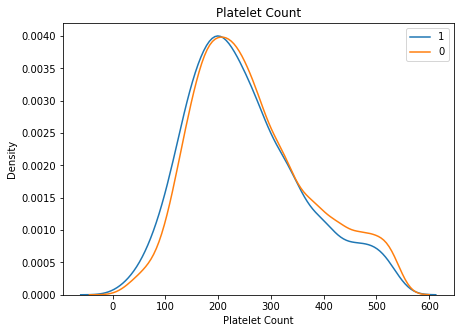

<Figure size 432x288 with 0 Axes>

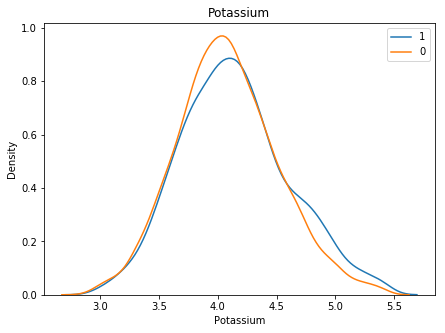

<Figure size 432x288 with 0 Axes>

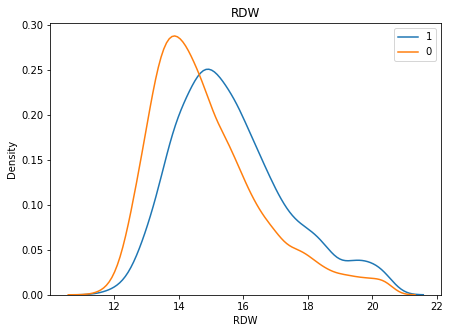

<Figure size 432x288 with 0 Axes>

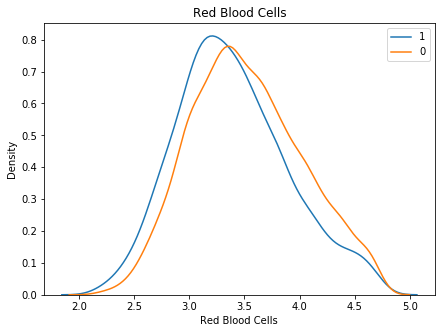

<Figure size 432x288 with 0 Axes>

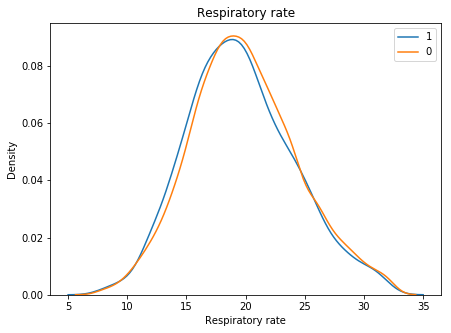

<Figure size 432x288 with 0 Axes>

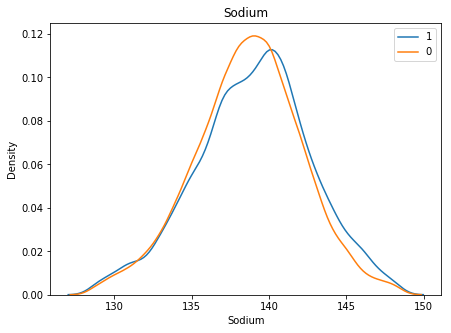

<Figure size 432x288 with 0 Axes>

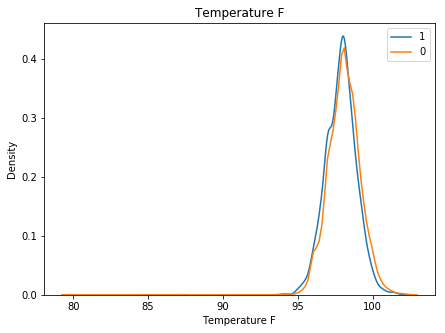

<Figure size 432x288 with 0 Axes>

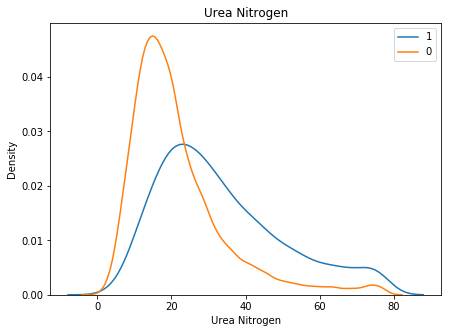

<Figure size 432x288 with 0 Axes>

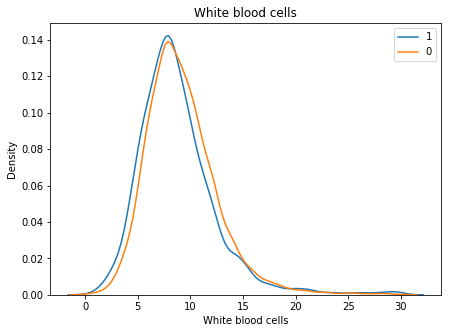

<Figure size 432x288 with 0 Axes>

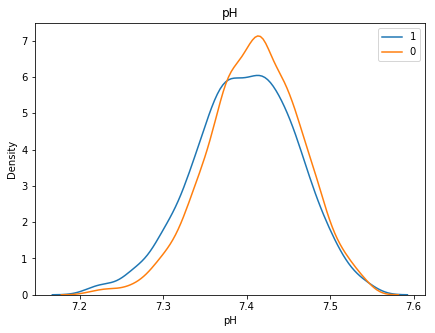

--> Training set counts:  
 0    6184
1    2031
Name: target, dtype: int64
--> Test set counts:  
 0    1568
1     486
Name: target, dtype: int64


<Figure size 432x288 with 0 Axes>

In [9]:
select_patients_and_select_chartevents('51881', 'acute_respiratory_failure',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('4019', 'hypertension',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('5849', 'acute_kidney_failure',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('2724', 'hyperlipidemia',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('2859', 'anemia',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('486', 'pneumonia',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('311', 'depression',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)

select_patients_and_select_chartevents('5859', 'chronic_kidney_disease',
                                       show_graphs=show_graphs, test_size=test_size,
                                       match_on=match_on, optional_exclusions=optional_exclusions)